In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import inv, svd, pinv
import math
import seaborn as sns
import itertools
from string import ascii_letters
import networkx as nx
import scipy
import scipy.cluster.hierarchy as sch
import sys
from sklearn.impute import KNNImputer
from matplotlib.lines import Line2D
import plotly.express as px
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn import manifold 
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats import kde

Load dataset and set empty values as NaN

In [2]:
data = pd.read_csv("../dataset/timeseries/timeseries.csv")
data = data.replace(to_replace =" ", value = np.nan)

C:\Users\david\AppData\Local\Temp\ipykernel_1600\1660088440.py:1: DtypeWarning: Columns (4,5,6,7,8,9,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,232,253,274,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,360,381,402,423,

As there is not a global response numeration we picked a group of questions based on the options presented.

In [3]:
usefulQuestions = ['VCF0310','VCF0313','VCF0601','VCF0602','VCF0603','VCF0604','VCF0606','VCF0608','VCF0609','VCF0622','VCF0623','VCF0624',
    'VCF0625','VCF0675','VCF0733','VCF0806','VCF0809','VCF0811','VCF0814','VCF0815','VCF0817','VCF0818','VCF0820','VCF0821','VCF0830','VCF0832',
    'VCF0834','VCF0837','VCF0838','VCF0839','VCF0842','VCF0843','VCF0844','VCF0847','VCF0848','VCF0848a','VCF0850','VCF0851','VCF0852','VCF0853',
    'VCF0854','VCF0867a','VCF0871','VCF0872','VCF0876a','VCF0877a','VCF0879','VCF0886','VCF0887','VCF0888','VCF0889','VCF0890','VCF0891','VCF0892',
    'VCF0893','VCF0894','VCF9003','VCF9004','VCF9005','VCF9013','VCF9014','VCF9015','VCF9016','VCF9017','VCF9018','VCF9038','VCF9039','VCF9040',
    'VCF9041','VCF9042','VCF9043','VCF9046','VCF9047','VCF9048','VCF9049','VCF9050','VCF9206','VCF9223','VCF9226','VCF9233','VCF9237','VCF9238',
    'VCF9239','VCF9244','VCF9245','VCF9246','VCF9248','VCF9249','VCF9251','VCF9254','VCF9255','VCF9267','VCF9268','VCF9269','VCF9270','VCF9271',
    'VCF9272','VCF9273','VCF9274'] # codes of useful questions

In [4]:
years = data.VCF0004.unique()
years

array([1948, 1952, 1954, 1956, 1958, 1960, 1962, 1964, 1966, 1968, 1970,
       1972, 1974, 1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992,
       1994, 1996, 1998, 2000, 2002, 2004, 2008, 2012, 2016, 2020],
      dtype=int64)

Number of questions per year present in the selected list

In [5]:
def getSharedColumns(dataframe, questionsList): 
    """Return the columns (questions) contained in every year in the dataframe in dictionary form {year: list of columns} 

    Parameters:
    dataframe -- dataframe
    questionsList -- list of codes of the questions
    """
    question_year = ["VCF0004"] # year code
    df = pd.DataFrame(dataframe, columns=  question_year + questionsList)
    years = dataframe.VCF0004.unique()
    columnsPerYear = {}
    for year in years:
        df_year = (
            df
            .query("VCF0004 == @year")
            .dropna(axis=1, how='all')
        )
        columnsPerYear[year] = df_year.columns
    return columnsPerYear

def getHeatMap(dataframe, questionsList, years): #given a dataFrame and a list of columns get the heatmap of years containing that column
    """Return the columns (questions) contained in every year in the dataframe in dictionary form {year: list of columns} 

    Parameters:
    dataframe -- dataframe
    questionsList -- list of codes of the questions
    years -- list of years considered
    """
    # get columns in every year
    columnsPerYear = getSharedColumns(dataframe, questionsList)

    #create heatmap
    df_confusion = pd.DataFrame({'year': years})
    for x in years:
        df_confusion[x] = 0
    
    for x in range(len(years)):
        for y in years:
            for elem in columnsPerYear[years[x]]:
                if elem in columnsPerYear[y]:
                    df_confusion.at[x, y] += 1

    # change row names to the years
    comDict = {x : years[x] for x in range(0,len(years))}
    df_confusion = (
        df_confusion
        .rename(index=comDict)
        .drop(["year"], axis=1)
    )
    fig, ax = plt.subplots(figsize=(10,10))
    matrix = np.triu(df_confusion, 1)
    # sns.set_context("paper", font_scale=2) 
    sns.heatmap(ax=ax,data=df_confusion, mask=matrix ,annot=True, annot_kws={"size":10}, fmt='d')




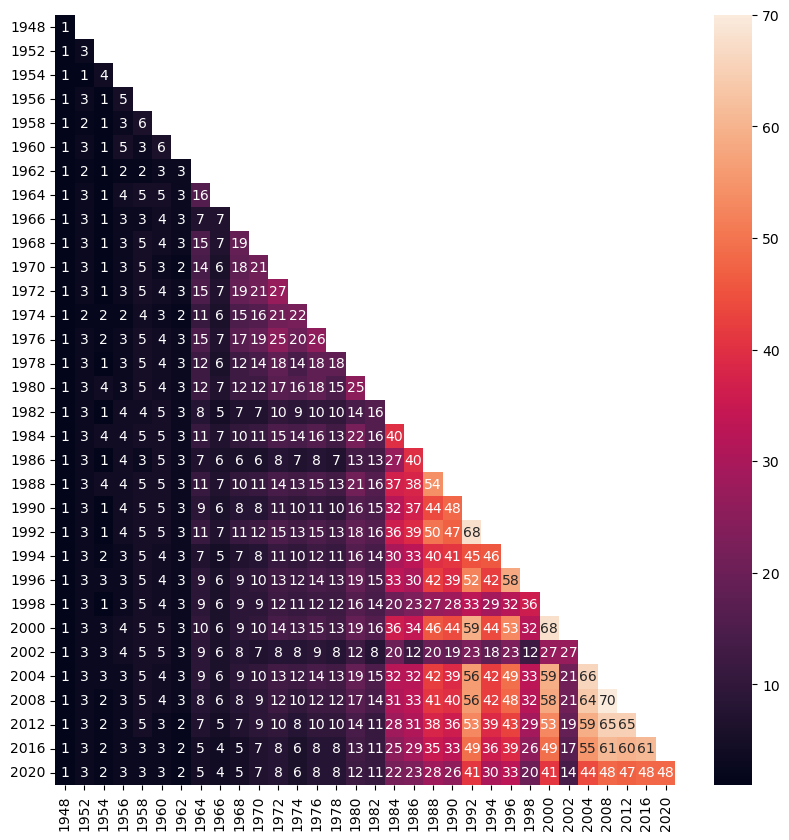

In [6]:
getHeatMap(dataframe=data, questionsList = usefulQuestions, years=years)

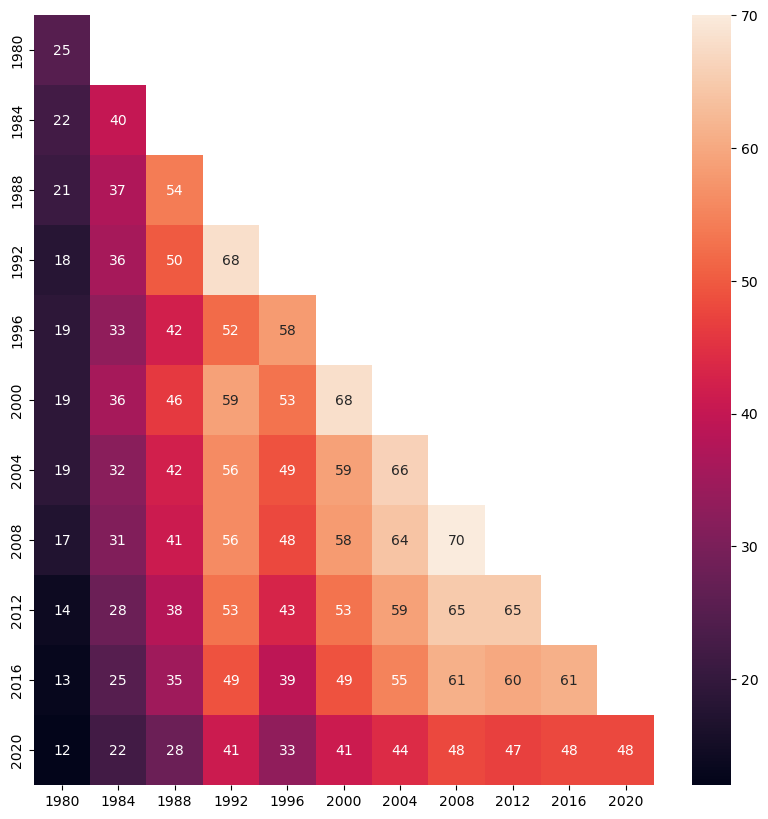

In [7]:
years2compare = [x for x in years if x >= 1980 and x % 4 == 0]
getHeatMap(dataframe=data, questionsList = usefulQuestions, years=years2compare)

As years previous to 1970 have little matching questions to the following ones I dropped years prior to 1970 for image clarity

In [8]:
def intersection(columnsPerYear, yearList):
    """Return question intersection in list form 

    Parameters:
    columnsPerYear -- dictionary {year: list(questions contained in that year)}
    years -- list of years considered
    """
    inter = set(data.columns)
    for x in yearList:
        inter = inter & set(columnsPerYear[x])
    return list(inter)


In [9]:
def Sort_Tuple(listOfTuples):
    """Sort list of tuples

    Parameters:
    columnsPerYear -- list of tuples
    """
    listOfTuples.sort(key = lambda x: len(x[0])*1000 + x[1]) # sorts so smaller first elements are placed first. If same lenght in the first element the value  is considered in ascending order
    return listOfTuples

In [10]:
def getSharedQuestions(dataset, questions):
    """Return dictionary {set of years: number of questions shared} 

    Parameters:
    dataset -- dataframe
    questions -- questions considered
    """
    # get questions contained in every year
    columnsPerYear = getSharedColumns(dataset, questions)
    yearsList = dataset.VCF0004.unique()
    result = {}
    sizeOfYearSets = list(range(2,5)) # sets of sizes contained in the list will be considered for the shared questions
    for numYears in sizeOfYearSets:
        yearDifference = 14 # minimum difference between first and last year
        threshold = 44 # threshold of shared questions, lower values will not be saved
        tupleList = list()
        for subset in itertools.combinations(yearsList, numYears):
            lint = intersection(columnsPerYear, list(subset)) # questions shared by years 'subset'
            if (
                len(lint)-1 >= threshold and 
                subset[-1] - subset[0] >= yearDifference and 
                subset[-1] > 2007 and subset[0] < 1993 # so only recent years are accounted
                ): 
                tupleList.append((subset, len(lint)-1)) # len(lint)-1 so VCF0004 "year code" is not considered
        tupleList = Sort_Tuple(tupleList)

        sharedQuestionsRange = 10 # range of total number of shared question considered (if maximum number of shared questions is x, lower than (x-sharedQuestionsRange) wont be considered)
        for elem in tupleList:
            if elem[1] >= tupleList[-1][1] - sharedQuestionsRange:
                result[elem[0]] = elem[1]
    return result

In [11]:
gsq = getSharedQuestions(data, usefulQuestions)
gsq

{(1992, 2016): 48,
 (1992, 2012): 52,
 (1992, 2008): 55,
 (1992, 1996, 2008): 44,
 (1992, 2000, 2016): 45,
 (1992, 2004, 2016): 47,
 (1992, 2012, 2016): 47,
 (1992, 2008, 2016): 48,
 (1992, 2000, 2012): 49,
 (1992, 2004, 2012): 51,
 (1992, 2000, 2008): 52,
 (1992, 2008, 2012): 52,
 (1992, 2004, 2008): 54,
 (1992, 2000, 2004, 2016): 44,
 (1992, 2000, 2012, 2016): 44,
 (1992, 2000, 2008, 2016): 45,
 (1992, 2004, 2012, 2016): 46,
 (1992, 2004, 2008, 2016): 47,
 (1992, 2008, 2012, 2016): 47,
 (1992, 2000, 2004, 2012): 48,
 (1992, 2000, 2008, 2012): 49,
 (1992, 2000, 2004, 2008): 51,
 (1992, 2004, 2008, 2012): 51}

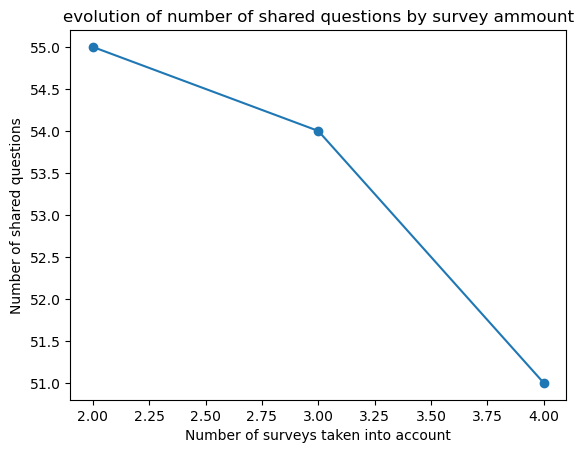

In [12]:
# number of shared questions based on subset size
numbOfQuestions = dict()
for key in gsq:
    if len(key) in numbOfQuestions.keys():
        numbOfQuestions[len(key)] = np.max([numbOfQuestions[len(key)], gsq[key]])
        
    else:
        numbOfQuestions[len(key)] = gsq[key]

x = list(numbOfQuestions.keys())
y = list(numbOfQuestions.values())
plt.ylabel('Number of shared questions')
plt.xlabel('Number of surveys taken into account')
plt.title('evolution of number of shared questions by survey ammount')
plt.plot(x,y, marker='o')

In [13]:
def intersect(dataset,questions,yearsSubset):
    """Return question intersection in list form 

    Parameters:
    dataset -- dataframe
    questions -- list of questions  considered
    yearsSubset -- years to intersect
    """
    columnsPerYear = getSharedColumns(dataset, questions)
    lint = intersection(columnsPerYear, list(yearsSubset)) 
    return lint 

# years selection

In [14]:
# yearsSubset = (1992, 2000, 2004, 2008,2012,2016)
# yearsSubset = (1992, 2004, 2016)
# yearsSubset = (1992, 2004, 2008, 2012)
yearsSubset = (1992, 2000, 2008)


lint = intersect(data,usefulQuestions,yearsSubset)
lint.remove("VCF0004") #remove year variable
len(lint)


52

In [15]:
# list of dataframes, one for every year in the yearsSubset
dataframes = list()
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    dataframes.append(data.query("VCF0004 == @year"))
    dataframes[i] = dataframes[i][lint]
    for col in dataframes[i]:
        dataframes[i][col] = pd.to_numeric(dataframes[i][col],errors='coerce')
    dataframes[i][dataframes[i] < 0] = np.nan

In [16]:
def eraseElementsDics(dataframes, dic):
    """Sets to NaN some values for every question

    Parameters:
    dataframes -- list of dataframes
    dic -- dictyonary {question: list(values to be NaN)}
    """
    for i in range(len(dataframes)):
        for elem in dic.keys():
            try:
                dataframes[i][elem] = dataframes[i][elem].replace(dic[elem],np.nan)
            except:
                pass

In [17]:
# for every question the values that mean missing
missingValues = {
    'VCF0310':[0,9],
    'VCF0313':[0,9],
    'VCF0601':[0],
    'VCF0602':[0],
    'VCF0603':[0],
    'VCF0604':[0,9],
    'VCF0606':[0,9],
    'VCF0608':[0,9],
    'VCF0609':[0,9], 
    'VCF0622':[0,9],
    'VCF0623':[0,9],
    'VCF0624':[0,9],
    'VCF0625':[0,9],
    'VCF0675':[8,9],
    'VCF0733':[9],
    'VCF0806':[0,9],
    'VCF0809':[0,9],
    'VCF0811':[0,9],
    'VCF0814':[0,9],
    'VCF0815':[0,9],
    'VCF0817':[0,9],
    'VCF0818':[9],
    'VCF0820':[0,9],
    'VCF0821':[0,9],
    'VCF0830':[0,9],
    'VCF0832':[0,9],
    'VCF0834':[0,9],
    'VCF0837':[0,9],
    'VCF0838':[0,9],
    'VCF0839':[0,9],
    'VCF0842':[0,9],
    'VCF0843':[0,9],
    'VCF0844':[8,9],
    'VCF0847':[0,8],
    'VCF0848':[0,9],
    'VCF0848a':[8,9],
    'VCF0850':[0,9],
    'VCF0851':[8,9],
    'VCF0852':[8,9],
    'VCF0853':[8,9],
    'VCF0854':[8,9],
    'VCF0867a':[7,8,9],
    'VCF0871':[0,8,9],
    'VCF0872':[0,8,9],
    'VCF0876a':[7,9],
    'VCF0877a':[7,9],
    'VCF0879':[8,9],
    'VCF0886':[8,9],
    'VCF0887':[8,9],
    'VCF0888':[8,9],
    'VCF0889':[8,9],
    'VCF0890':[8,9],
    'VCF0891':[8,9],
    'VCF0892':[8,9],
    'VCF0893':[8,9],
    'VCF0894':[8,9],
    'VCF9003':[98,99],
    'VCF9004':[98,99],
    'VCF9005':[98,99],
    'VCF9013':[8,9],
    'VCF9014':[8,9],
    'VCF9015':[8,9],
    'VCF9016':[8,9],
    'VCF9017':[8,9],
    'VCF9018':[8,9],
    'VCF9038':[8,9],
    'VCF9039':[8,9],
    'VCF9040':[8,9],
    'VCF9041':[8,9],
    'VCF9042':[8,9],
    'VCF9043':[0,9],
    'VCF9046':[7,8,9],
    'VCF9047':[7,8,9],
    'VCF9048':[7,8,9],
    'VCF9049':[7,8,9],
    'VCF9050':[7,8,9],
    'VCF9206':[],
    'VCF9223':[],
    'VCF9226':[],
    'VCF9233':[],
    'VCF9237':[],
    'VCF9238':[],
    'VCF9239':[],
    'VCF9244':[],
    'VCF9245':[],
    'VCF9246':[],
    'VCF9248':[],
    'VCF9249':[],
    'VCF9251':[],
    'VCF9254':[],
    'VCF9255':[],
    'VCF9267':[],
    'VCF9268':[],
    'VCF9269':[],
    'VCF9270':[],
    'VCF9271':[],
    'VCF9272':[],
    'VCF9273':[],
    'VCF9274':[],
    'VCF9275':[]}


In [18]:
eraseElementsDics(dataframes, missingValues)

## list of changes to variables

### VCF0847 
HOW MUCH GUIDANCE FROM RELIGION has options
1. Some
2. Quite a bit
3. A great deal
5. Religion not important

5 will turn into option 0

### VCF0867a, VCF0876a, VCF0877a, VCF9237, VCF0872

have non-consecutive numeric options, these will turn continuous

Will be changed so all four options are consecutive

### VCF0609
GOVERNMENT OFFICIALS CARE WHAT PEOPLE LIKE
RESPONDENT THINK
1. Agree
2. Disagree
3. Neither agree nor disagree (1988 and later only)

Options will be changed so point 3 is in between


In [19]:
for i in range(len(dataframes)):
    # try:
    dataframes[i].VCF0609 = dataframes[i].VCF0609.replace([2.0,3.0],[3.0,2.0])
    dataframes[i].VCF0847 = dataframes[i].VCF0847.replace([5.0],[0.0])
    dataframes[i].VCF0867a = dataframes[i].VCF0867a.replace([4.0,5.0],[3.0,4.0])
    dataframes[i].VCF0872 = dataframes[i].VCF0872.replace([3.0,5.0],[2.0,3.0])
    dataframes[i].VCF0876a = dataframes[i].VCF0876a.replace([4.0,5.0],[3.0,4.0])
    dataframes[i].VCF0877a = dataframes[i].VCF0877a.replace([4.0,5.0],[3.0,4.0])
    dataframes[i].VCF9237 = dataframes[i].VCF9237.replace([4.0,5.0],[3.0,4.0])
    # except:
    #     pass

In [20]:
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex(sorted(dataframes[i].columns), axis=1)

## Flip answers so coherent 

some questions have the codes inverted, where lowest code implies maximum satisfaction with statement

In [21]:
questionsToFlip = ['VCF0606','VCF0608','VCF0609','VCF0675','VCF0806','VCF0809','VCF0811','VCF0815','VCF0817','VCF0818',
    'VCF0830','VCF0832','VCF0834','VCF0842','VCF0844','VCF0850','VCF0851','VCF0852','VCF0853','VCF0854','VCF0867a','VCF0871',
    'VCF0872','VCF0876a','VCF0877a','VCF0879','VCF0886','VCF0887','VCF0888','VCF0889','VCF0890','VCF0891','VCF0892','VCF0893',
    'VCF0894','VCF9013','VCF9014','VCF9015','VCF9016','VCF9017','VCF9018','VCF9039','VCF9040','VCF9041','VCF9042','VCF9046','VCF9047',
    'VCF9048','VCF9049','VCF9050','VCF9223','VCF9233','VCF9237','VCF9238','VCF9239','VCF9244','VCF9245','VCF9251','VCF9254','VCF9255',
    'VCF9270','VCF9271','VCF9272','VCF9273','VCF9274']

In [22]:
def flipAnswers(DataframeList, flipQuestions):
    """Return the list of dataframes with the selected questions' code

    Parameters:
    DataframeList -- list of dataframes
    DataframeList -- list of questions to flip 
    """
    for i in range(len(DataframeList)):
        for column in flipQuestions:
            try:
                dataframes[i][column] = dataframes[i][column].max() + dataframes[i][column].min() - dataframes[i][column]
            except:
                pass

In [23]:
flipAnswers(dataframes,questionsToFlip)

## Rename questions

In [24]:
questionsResume = {
  'VCF0310': "Interest in Elections",
  'VCF0313': "Interest in public affairs",
  'VCF0601': "Approve participation in protests",
  'VCF0602': "Approve civil dissobedience",
  'VCF0603': "Approve demonstrations",
  'VCF0604': "Government Waste Money",
  'VCF0606': "Federal wasted money",
  'VCF0608': "Government crooked",
  'VCF0609': "Government care in public opinion",
  'VCF0622': "Government pays attention to public opinion",
  'VCF0623': "Parties makes government pay attention",
  'VCF0624': "Elections makes government pay attention",
  'VCF0625': "Congressmen attention to constituents",
  'VCF0733': "Frequency of political discussions",
  'VCF0675': "Trust in media",
  'VCF0806': "Government Health Insurance",
  'VCF0809': "Guaranteed Jobs and Income",
  'VCF0811': "Urban unrest force-solve",
  'VCF0814': "Civil rights pushed too fast",
  'VCF0815': "Segregation vs desegregation",
  'VCF0817': "Use school bus to integrate",
  'VCF0818': "Ensure jobs/house for blacks",
  'VCF0820': "Whites favor segregation",
  'VCF0821': "Black favor desegregation",
  'VCF0830': "Aid to Blacks",
  'VCF0832': "Protect rights of accused",
  'VCF0834': "Women equal role",
  'VCF0837': "Abortion allowed",
  'VCF0838': "Abortion allowed by law",
  'VCF0839': "Government Services-Spending Scale",
  'VCF0842': "Harder environmental regulations",
  'VCF0843': "Defense Spending Scale",
  'VCF0844': "Use of military force",
  'VCF0847': "Guidance from religion",
  'VCF0848': "Concern conventional war",
  'VCF0848a':"Concern nuclear war",
  'VCF0850': "Authority of the Bible",
  'VCF0851': "Newer lifestyles contribute to society",
  'VCF0852': "Should Adjust View of Moral Behavior to Changes",
  'VCF0853': "Should be More Emphasis on Traditional Values",
  'VCF0854': "Tolerance on different moralities",
  'VCF0867a':"Preference on blacks when hiring",
  'VCF0871': "Better economy than past year",
  'VCF0872': "Better economy next year",
  'VCF0876a':"Protection to homosexuals",
  'VCF0877a':"Gays in military",
  'VCF0879': "Allow more immigrants",
  'VCF0886': "Federal Spending- Poor/Poor People",
  'VCF0887': "Federal Spending- child care",
  'VCF0888': "Federal Spending- Dealing with Crime",
  'VCF0889': "Federal Spending- AIDS",
  'VCF0890': "Federal Spending- Public Schools",
  'VCF0891': "Federal Spending- Students",
  'VCF0892': "Federal Spending- foreigners",
  'VCF0893': "Federal Spending- homeless",
  'VCF0894': "Federal Spending- Welfare Programs",
  'VCF9003': "Opinion- Evangelical groups",
  'VCF9004': "Opinion- elderly",
  'VCF9005': "Opinion- supreme court",
  'VCF9013': "Ensure Equal Opportunity to Succeed",
  'VCF9014': "Too far pushing equal rights",
  'VCF9015': "Big problem not equal chance",
  'VCF9016': "Life unfair by default",
  'VCF9017': "Should Worry less about How Equal People Are",
  'VCF9018': "All should be Treated Equally",
  'VCF9038': "Guaranteed equal Opportunity by govt",
  'VCF9039': "Blacks have it difficult to Succeed",
  'VCF9040': "Blacks should Not be favored",
  'VCF9041': "Blacks must try harder",
  'VCF9042': "Blacks Gotten less than deserved",
  'VCF9043': "School prayer",
  'VCF9046': "Federal Spending- food stamps",
  'VCF9047': "Spending: Environment",
  'VCF9048': "Federal Spending- science",
  'VCF9049': "Spending: Social Security",
  'VCF9050': "Federal Spending- assist blacks",
  'VCF9206': "Presidency and congress splited",
  'VCF9223': "Immigrants take jobs away",
  'VCF9226': "Unemployment increase",
  'VCF9233': "Torture",
  'VCF9237': "Death penalty",
  'VCF9238': "Should be harder to buy a Gun ",
  'VCF9239': "Importance of gun control",
  'VCF9244': "Trust other people",
  'VCF9245': "Satisfied with life",
  'VCF9246': "Child attribute: curiosity vs good manners",
  'VCF9248': "Child attribute: considerate vs well-behaved",
  'VCF9249': "Child attribute: independence vs respect for elders",
  'VCF9251': "Knowledge political issues",
  'VCF9254': "Satisfied with democracy in U.S. (Former)",
  'VCF9255': "Satisfied with democracy in U.S. (Latter)",
  'VCF9267': "Opinion- muslims",
  'VCF9268': "Opinion- rich",
  'VCF9269': "Opinion- christians",
  'VCF9270': "Hardworking for whites",
  'VCF9271': "Hardworking for blacks",
  'VCF9272': "Hardworking for Hispanic-Americans",
  'VCF9273': "Hardworking Asian Americans",
  'VCF9274': "Black influence"
}

In [25]:
sns.set_theme(style="white")

for i in range(len(dataframes)):
    dataframes[i].rename(questionsResume,axis=1,inplace=True)

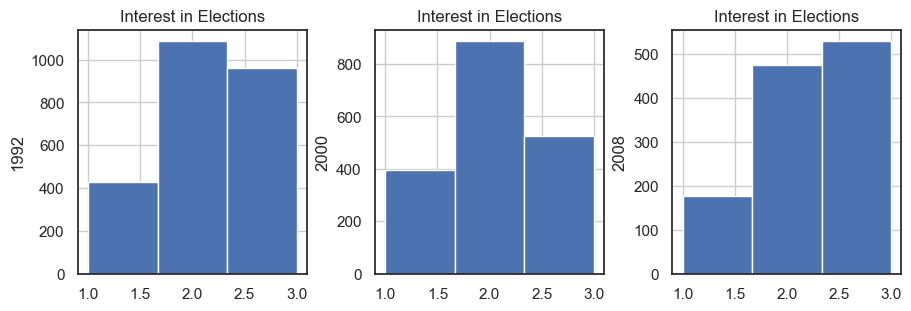

In [26]:
length = len(dataframes)
for col in dataframes[0]:  
    _, axs = plt.subplots(1, length, figsize=(3*length,3), constrained_layout=True)
    for i in range(len(dataframes)):
        axs[i].set_title(yearsSubset[i])
        axs[i].set_ylabel(yearsSubset[i])
        uniq = dataframes[i][col].unique() 
        uniq = uniq[~np.isnan(uniq)]
        nbins = math.floor(max(uniq) - min(uniq))
        dataframes[i].hist(column=col, bins = nbins + 1, ax=axs[i])
    break

## Missing deletion

In [27]:
missingThreshold = 0.3

In [28]:
for i in range(len(dataframes)):
    dataframes[i]=(dataframes[i]-dataframes[i].min())/(dataframes[i].max()-dataframes[i].min())

In [29]:
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex((dataframes[0].isna().sum()/len(dataframes[i])).sort_values(ascending=False,kind='mergesort').index, axis=1)

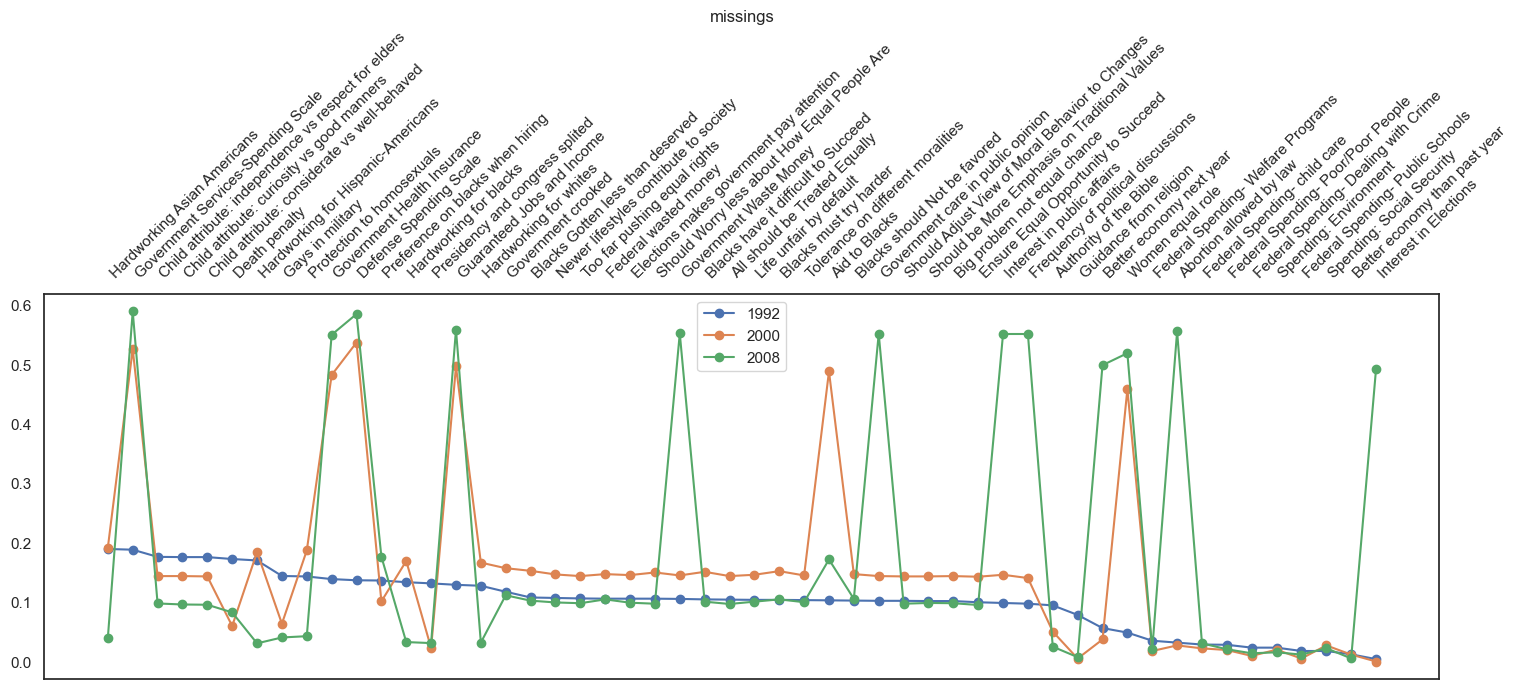

In [30]:
#missing rates

fig, ax = plt.subplots(figsize=(18, 5))
for i in range(len(dataframes)):
    cols = dataframes[i].columns
    y = list(dataframes[i].isna().sum()/len(dataframes[i]))

    plt.tick_params(labelbottom=False,labeltop=True)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
    ax.plot(cols,y, '-o', label=str(yearsSubset[i]))
    plt.title("missings")
plt.legend()

In [31]:
for _ in range(2): # for some reason a variable doesn't drop the first time
    todrop=list()
    for i in range(len(dataframes)):
        cols = dataframes[i].columns
        rate = list(dataframes[i].isna().sum()/len(dataframes[i]))
        # print([cols[rate.index(x)] for x in rate if x >=missingThreshold])
        todrop.append([cols[rate.index(x)] for x in rate if x >=missingThreshold]) #variables exceding threshold
    
    todrop = np.unique(np.concatenate(todrop, axis=0))
    for i in range(len(dataframes)):
        #drop variables
        dataframes[i].drop(todrop, axis=1, inplace=True)

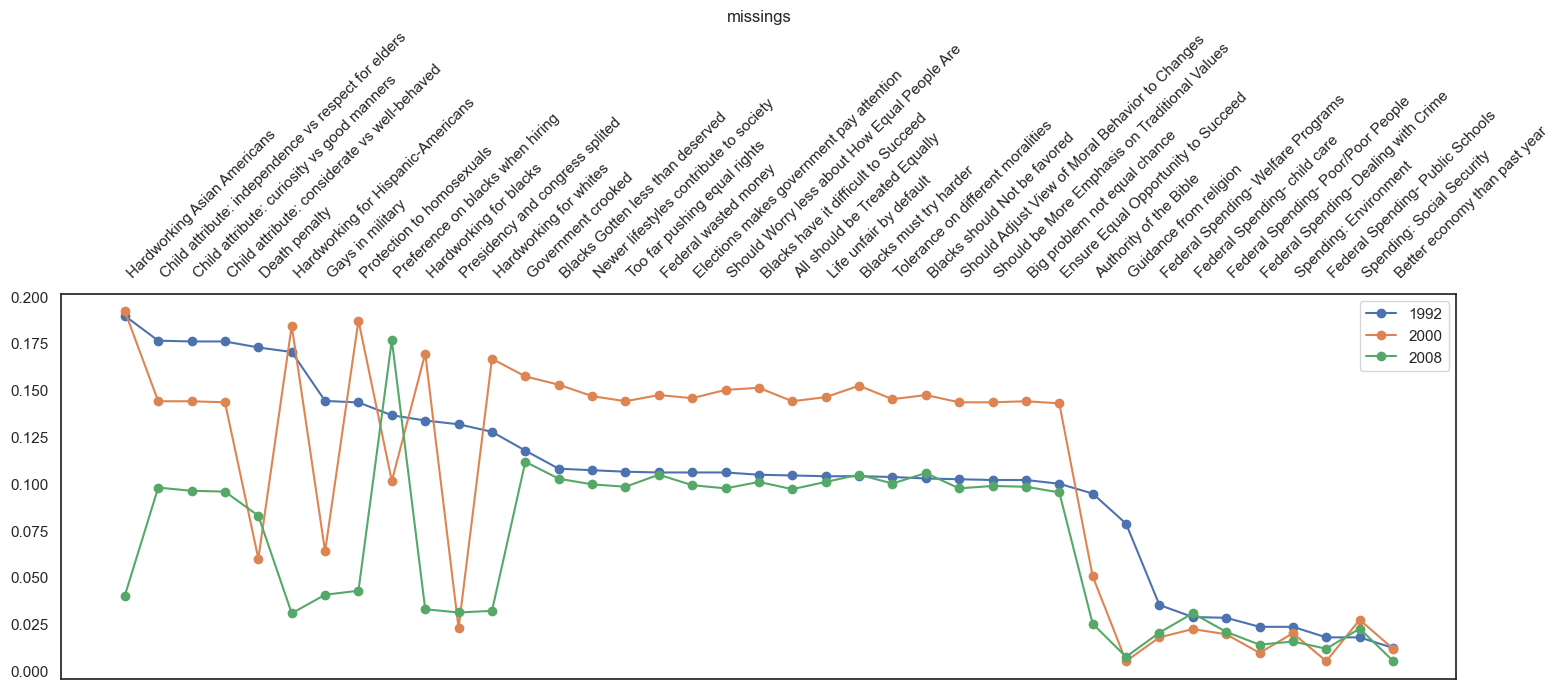

In [32]:
#missing rates

fig, ax = plt.subplots(figsize=(18, 5))
for i in range(len(dataframes)):
    cols = dataframes[i].columns
    y = list(dataframes[i].isna().sum()/len(dataframes[i]))

    plt.tick_params(labelbottom=False,labeltop=True)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
    ax.plot(cols,y, '-o', label=str(yearsSubset[i]))
    plt.title("missings")
plt.legend()

Missing imputation with KNN

In [33]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
cols = dataframes[0].columns
# start the KNN training
for i in range(len(dataframes)):
    imputer = KNNImputer(n_neighbors=1, weights="uniform")
    imputed_training = imputer.fit_transform(dataframes[i])
    dataframes[i] = pd.DataFrame(imputed_training, columns=cols)

variance of the data

In [34]:
for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].reindex(dataframes[0].var().sort_values(ascending=False).index, axis=1)

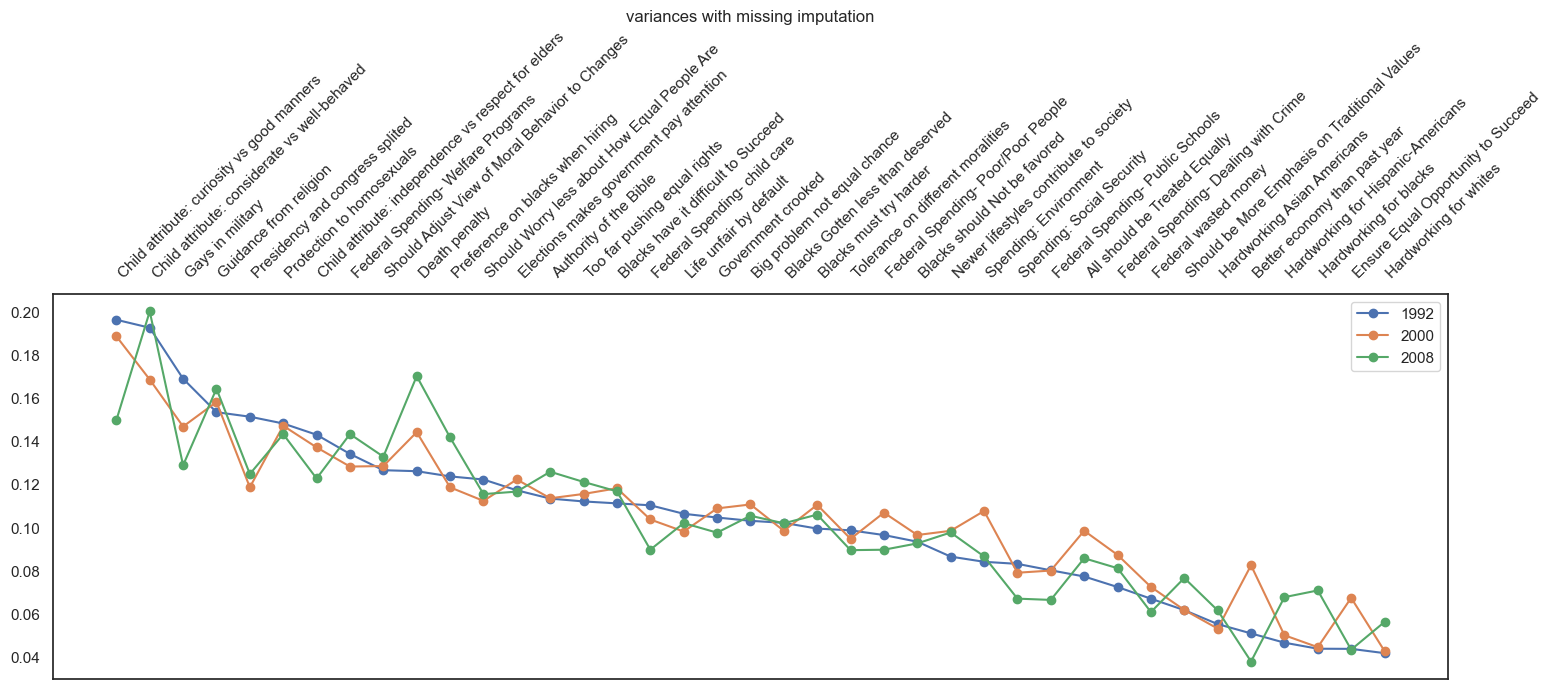

In [35]:
fig, ax = plt.subplots(figsize=(18, 5))
for i in range(len(dataframes)):
    cols = dataframes[i].columns
    y = list(dataframes[i].var())

    plt.tick_params(labelbottom=False,labeltop=True)
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
    ax.plot(cols,y, '-o', label=str(yearsSubset[i]))
    plt.title("variances with missing imputation")
plt.legend()

# Low dimensional embedding

Addition of attributes to the set of questions

In [36]:
def copyDataframeArray(arr):
    """ copy list of dataframes by value

    Parameters:
    arr -- list of dataframes
    """
    result = list()
    for i in range(len(arr)):
        result.append(arr[i].copy())
    return result

In [37]:
dataframesWithAttributes = copyDataframeArray(dataframes)

In [38]:
# Party
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0303
    addGroup = pd.to_numeric(addGroup,errors='coerce') # some codes are in interger form others in float form
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["party"] = addGroup
    dataframesWithAttributes[i].party = dataframesWithAttributes[i].party.replace([0.0,1.0,2.0,3.0],["DK","Democrats","Independents","Republicans"]) # DK = Dont know, missing values


In [39]:
# Age
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0102
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["age"] = addGroup
    dataframesWithAttributes[i]["age"] = dataframesWithAttributes[i]["age"].replace([0,1,2,3,4,5,6,7],['DK','17-34', '17-34','35-54','35-54','55+','55+','55+'])

In [40]:
# Class
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0148a
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["class"] = addGroup
    dataframesWithAttributes[i]["class"] = dataframesWithAttributes[i]["class"].replace([1,2,3,4,5,6,9],['Working','Working','Working','Middle','Middle','Middle','DK'])

In [41]:
# Etnicity
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0106
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["race"] = addGroup
    dataframesWithAttributes[i]["race"] = dataframesWithAttributes[i]["race"].replace([1,2,3,0,9],['White','Black','DK','DK','DK'])

In [42]:
# Gender
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0104
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["sex"] = addGroup
    dataframesWithAttributes[i]["sex"] = dataframesWithAttributes[i]["sex"].replace([1,2,3],['Male','Female','DK'])

In [43]:
# Income
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0114
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["income"] = addGroup
    dataframesWithAttributes[i]["income"] = dataframesWithAttributes[i]["income"].replace([1,2,3,4,5,0],['Poor','Poor','34-66%','Rich','Rich','DK'])    # poor = 0-33%, rich = 67-100%, 

In [44]:
# Education
for i in range(len(yearsSubset)):
    year = yearsSubset[i]
    addGroup = data.query("VCF0004 == @year").VCF0140
    addGroup = pd.to_numeric(addGroup,errors='coerce')
    addGroup = list(addGroup)
    dataframesWithAttributes[i]["education"] = addGroup
    dataframesWithAttributes[i]["education"] = dataframesWithAttributes[i]["education"].replace([1,2,3,4,5,6,8,9],['no college','no college','no college','no college','college','college','DK','DK'])

In [45]:
# all subset' dataframes into a single one
dfsCombined = pd.concat(dataframesWithAttributes)
dfsCombined = dfsCombined.reset_index(drop=True)

Some useful functions

In [46]:
def differByAttAndplotCenters(data, points2d, id,  attributes, title, plotGeneral=True, plotIntermediates = False):
    """ For every community in an attribute get all the users' locations, plot centers for 

    Parameters:
    dfs -- dataframe containing all users
    points2d -- 2d coordinates for all users in dfs
    categ -- attribute to plot
    title -- title of the plot
    plotGeneral -- plot centers of all years
    plotIntermediates -- plot centers of every year individually
    """
    # points2d contains the points for all years, locate the year it pertain
    separators = list()
    for i in range(len(yearsSubset)):
        separators.append(len(data[i]))
    separators = [0] + separators
    cumulativeSeparators = list(np.cumsum(separators))


    points2dByYear = list()
    for i in range(len(yearsSubset)):
        points2dByYear.append(points2d[cumulativeSeparators[i]:cumulativeSeparators[i+1]])

    dens_perCategory = list()
    for cat in range(len(points2dByYear)):
        categInYear = list(data[cat][id])
        separator = data[0].columns.get_loc('party')
        indicators = data[0].columns[separator:]
        axx = {x:[] for x in data[0][indicators[indicators.get_loc(id)]]}
        for j in range(len(points2dByYear[cat])):
            for key in axx:
                if categInYear[j] == key:
                    axx[key].append(points2dByYear[cat][j])
        dens_perCategory.append(axx)
        
    
    markers = ['v', 'X', 'o','$A$','$B$','$C$','$D$','$E$']
    colors = ["lightblue","orange","green","violet", 'blue', 'yellow']
    fig, axs = plt.subplots(1, len(yearsSubset), figsize=(32, 8))

    fig.suptitle(f"{attributes[0]} against {attributes[1]}")
    fig.suptitle(title)
    users = list()
    centroid = list()
    for i in range(len(yearsSubset)):
        for att in range(len(attributes)):
            
            users.append(np.array(dens_perCategory[i][str(attributes[att])]))
            centroid.append(meanPoints(users[-1]))
            try:
                x = users[-1][:,0]
                y = users[-1][:,1]
                axs[i].scatter(x,y, s=10,color=colors[att])
                axs[i].set_title(str(yearsSubset[i]))
            except:
                pass
        custom_lines = [Line2D([0], [0], color=colors[c], lw=4) for c in range(len(colors))]
        axs[i].legend(custom_lines, attributes)

    for i in range(len(yearsSubset) * len(attributes)):
            axs[math.floor(i/len(attributes))].scatter(centroid[i][0],centroid[i][1],edgecolors='black', s=500, marker=markers[i % len(attributes)],color=colors[i % len(attributes)])

    if (plotIntermediates):
        plt.show()
    else:
        plt.close()

    if plotGeneral:
        fig, axs = plt.subplots(1, 1, figsize=(6, 6))
        fig.suptitle(f"{title}:  {attributes[0]} against {attributes[1]}")
        axs.scatter(points2d[:,0],points2d[:,1], s=10,color='lightcoral')
        for i in range(len(yearsSubset) * len(attributes)):
            axs.scatter(centroid[i][0],centroid[i][1], s=200, edgecolors='black',marker=markers[i % len(attributes)],color=colors[math.floor(i/len(attributes))])

            custom_lines = [Line2D([0], [0], color=colors[c], lw=4) for c in range(len(colors))]
            axs.legend(custom_lines, yearsSubset,fontsize="large")
        plt.show()

    return dens_perCategory

In [47]:
def meanPoints(coords):
    """ get Mean point 'center' for N-dimensional set of points 
    
    Parameters:
    coords: list of coordinates
    """
    res = list()
    for i in range(len(coords[0])):
        res.append(np.mean(coords[:,i]))
    return tuple(res)
    # return (np.mean(coords[:,0]), np.mean(coords[:,1])) 2d

In [48]:
def redBlueHeatmap(points2d, attributes, dens_perGroup, attName):
    """ Plot dominance map, how dominant are two communities within an attribute in every sector of the embedding

    Parameters:
    dfs -- dataframe containing all users
    attributes -- pair of communities in an attribute to plot
    dens_perGroup -- attribute to plot
    attName -- attribute name
    """
    # only consider if attribute lenght is 2
    if (len(attributes)!= 2):
        return

    # find bounding box
    points2d[:,0]
    bbox = {
        'minX': np.min(points2d[:,0]),
        'maxX': np.max(points2d[:,0]),
        'minY': np.min(points2d[:,1]),
        'maxY': np.max(points2d[:,1])
    }
    plotRangeX = np.arange(
        math.floor(bbox['minX']-0.5),
        math.ceil(bbox['maxX']+1),
        0.5)
    plotRangeY = np.arange(
        math.floor(bbox['minY']-0.5),
        math.ceil(bbox['maxY']+1),
        0.5)

    # custom color map
    cmap_reversed = matplotlib.cm.get_cmap('seismic').reversed()
    cmap_reversed.set_bad('lightgray',1.)

    # generate the plot
    for i in range(len(yearsSubset)):
        fig, ax = plt.subplots(figsize=(15,12))
        lsD = np.array(dens_perGroup[i][attributes[0]])
        lsD = np.round(lsD, decimals=3)
        x = lsD[:,0]
        y = lsD[:,1]
        histDem, xbinsDem, ybinsDem, imDem = ax.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap = 'plasma')
        plt.close()

        ls = np.array(dens_perGroup[i][attributes[0]] + dens_perGroup[i][attributes[1]])
        l = len(ls)
        ls = np.round(ls, decimals=3)
        fig, ax = plt.subplots(figsize=(15,12))

        x = ls[:,0]
        y = ls[:,1]

        hist, xbins, ybins, im = ax.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap = 'plasma')
        plt.close()
        hist = histDem / hist 
        masked_array = np.ma.array (hist, mask=np.isnan(hist))

        plt.figure(figsize=(6,6))
        plt.title(str(yearsSubset[i]) + "    Placement by " + str(attName))
        plt.imshow(np.flip(masked_array.T, axis=0),interpolation='nearest' ,cmap=cmap_reversed)
        plt.axis('off')
        cbar = plt.colorbar(shrink=0.8,ticks=[0,0.5,1])
        cbar.ax.set_yticklabels([attributes[1], '', attributes[0]])
        plt.show()


In [49]:
def interactivePlot(dfs, points2d, categ, title): 
    """ Generate interactive plot

    Parameters:
    dfs -- dataframe containing all users
    points2d -- 2d coordinates for all users in dfs
    categ -- attribute to plot
    title -- title of the plot
    """

    if categ not in dfs.columns:
        return

    labels = list(dfs[categ])

    fig_2d = px.scatter(
        points2d, x=0, y=1, width=700, height=500,
        custom_data=[labels], 
            title=title,
        color=labels , labels={'color': 'Question'}
    )

    fig_2d.update_traces(
        hovertemplate="<br>".join([
            "Question: %{customdata[0]}"
        ])
    )

    fig_2d.show()

# PCA

PCA could be used instead. metric-MDS and PCA behave the same when measuring using euclidean.

very similar results to the ones obtained with ISOMAP

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def customPCA(dfs, dim=2):
    separator = dfs.columns.get_loc('party')
    features = dfs.iloc[:, :separator].values
    x = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(x)
    print(f"explained variance {sum(pca.explained_variance_ratio_)}")
    return principalComponents

In [51]:
points2d = customPCA(dfs=dfsCombined,dim=2) #get 2dpoints in the embedding


explained variance 0.21392143815449954


# Isomap

Generation of the embedding


ISOMAP coordinates are tricky, due to the structure of the data, having no gaps, the euclidean distance and geodesic distance is very similar.

Using geodesic is not possible in some ocasions such as the application of the null model simulation.



In [52]:
def customISOMAP(dfs, dim, k):
    """ Data dimensionality reduction using ISOMAP

    Parameters:
    dfs -- dataframe containing all users
    dim -- number of dimensions of the generated embedding
    """

    iso = manifold.Isomap(
        n_neighbors=k, 
        n_components=dim, 
        n_jobs=-1,
        path_method='D',
        eigen_solver='dense'
        )

    separator = dfs.columns.get_loc('party') #only consider columns previous to 'party'
    features = dfs.iloc[:, :separator]

    proj_2d = iso.fit_transform(features)
    return proj_2d

In [53]:
points2d = customISOMAP(dfs=dfsCombined,dim=2, k=10) #get 2dpoints in the embedding

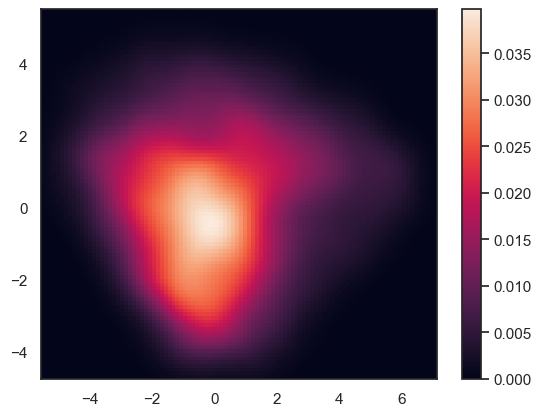

In [54]:
#Density map

#  x,y coordinates of 2dpoints
x = points2d[:,0]
y = points2d[:,1]


nbins=100
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.colorbar()
plt.show()

In [55]:
interactivePlot(dfsCombined, points2d, 'party', 'By partishanship')

# find centers for every attribute

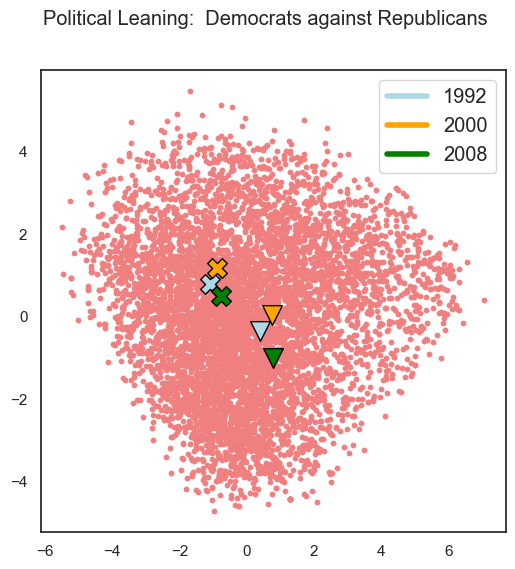

In [56]:
dens_perParty       = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='party', attributes = ['Democrats','Republicans'], title='Political Leaning' , plotGeneral=True, plotIntermediates=False)
dens_perAge         = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='age', attributes = ['17-34', '55+'], title='Age', plotGeneral=False, plotIntermediates=False)
dens_perClass       = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='class', attributes = ['Working','Middle'], title='Social Class', plotGeneral=False, plotIntermediates=False)
dens_perRace        = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='race', attributes = ['White','Black'], title='Ethnicity', plotGeneral=False, plotIntermediates=False)
dens_perSex         = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='sex', attributes = ['Male','Female'], title='Gender', plotGeneral=False, plotIntermediates=False)
dens_perIncome      = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='income', attributes = ['Poor','Rich'], title='Income', plotGeneral=False, plotIntermediates=False)
dens_perEducation   = differByAttAndplotCenters(dataframesWithAttributes, points2d,id='education', attributes = ['no college','college'], title='Education', plotGeneral=False, plotIntermediates=False)

C:\Users\david\AppData\Local\Temp\ipykernel_1600\3427989028.py:55: RuntimeWarning:

invalid value encountered in true_divide



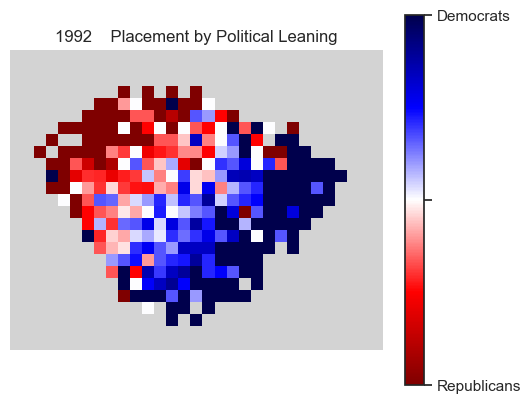

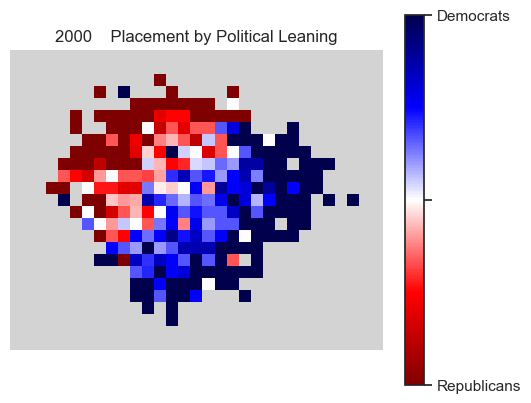

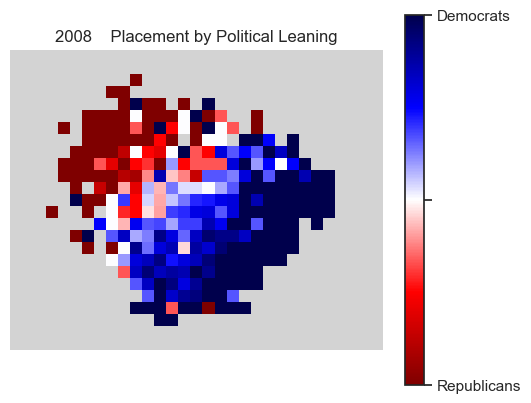

In [57]:
redBlueHeatmap(points2d,attributes = ['Democrats','Republicans'], dens_perGroup=dens_perParty, attName='Political Leaning')
# redBlueHeatmap(points2d,attributes = ['Working','Middle'], dens_perGroup=dens_perClass, attName='class')
# redBlueHeatmap(points2d,attributes = ['17-34', '55+'], dens_perGroup=dens_perAge, attName='age')
# redBlueHeatmap(points2d,attributes = ['White', 'Black'], dens_perGroup=dens_perRace, attName='ethnicity')
# redBlueHeatmap(points2d,attributes = ['Male', 'Female'], dens_perGroup=dens_perSex, attName="sex")
# redBlueHeatmap(points2d,attributes = ['Poor', 'Rich'], dens_perGroup=dens_perIncome, attName="income")
# redBlueHeatmap(points2d,attributes = ['college', 'no college'], dens_perGroup=dens_perEducation, attName="education")


In [58]:
def plotCentersSubset(objs):
    """ plot centers of a set of communities

    Parameters:
    objs -- list(dictionary for an attribute) each dictionary of the following form {community:list(users)}
    """
    plt.figure(figsize=(8,8))
    for categ in objs:
        for sub in np.array(list(categ[2].keys()))[:2]:
            center = (meanPoints(np.array(categ[2][sub])))
            plt.scatter(center[0],center[1], label=sub)
            plt.annotate(sub.capitalize(), (center[0],center[1]), size=20)
    plt.axis('equal')
    plt.show()

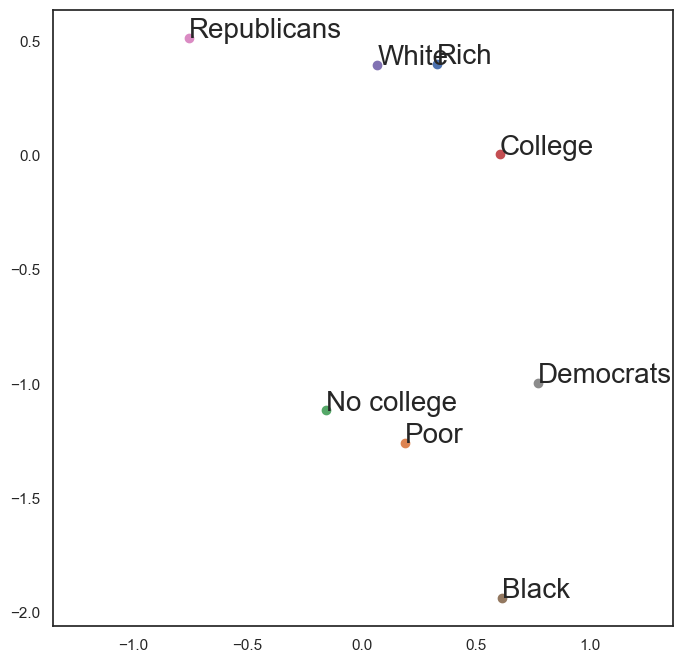

In [59]:
plotCentersSubset([dens_perIncome,dens_perEducation,dens_perRace,dens_perParty])

In [60]:
def locationCenters(objs):
    """ Returns center coords for every community in dictionary form

    Parameters:
    objs -- list(dictionary for an attribute) each dictionary of the following form {community:list(users)}
    """
    attr = dict()
    for categ in objs:
        for sub in np.array(list(categ[2].keys()))[:2]:
            center = (meanPoints(np.array(categ[2][sub])))
            attr[sub] = center[0],center[1]
        
    return attr

In [61]:
attr = locationCenters([dens_perIncome,dens_perEducation,dens_perRace,dens_perParty])

print(math.dist(attr['Republicans'], attr['college']))
print(math.dist(attr['Republicans'], attr['no college']))
print(math.dist(attr['Democrats'], attr['college']))
print(math.dist(attr['Democrats'], attr['no college']))

1.4528304048266978
1.736553208839497
1.0115265514529101
0.9340382531219011


In [62]:
attributesData = { # variable containing every attributes' data
    'party':dens_perParty,
    'class':dens_perClass,
    'race':dens_perRace,
    'sex':dens_perSex,
    'age': dens_perAge,
    'income': dens_perIncome,
    'education': dens_perEducation
}

subcats = { # communities  within each attribute
    'party':['Democrats','Republicans'],
    'class':['Middle','Working'],
    'race':['White','Black'],
    'sex':['Female','Male'],
    'age': ['17-34', '55+'],
    'education':['no college','college'],
    'income':['Poor','Rich']
}

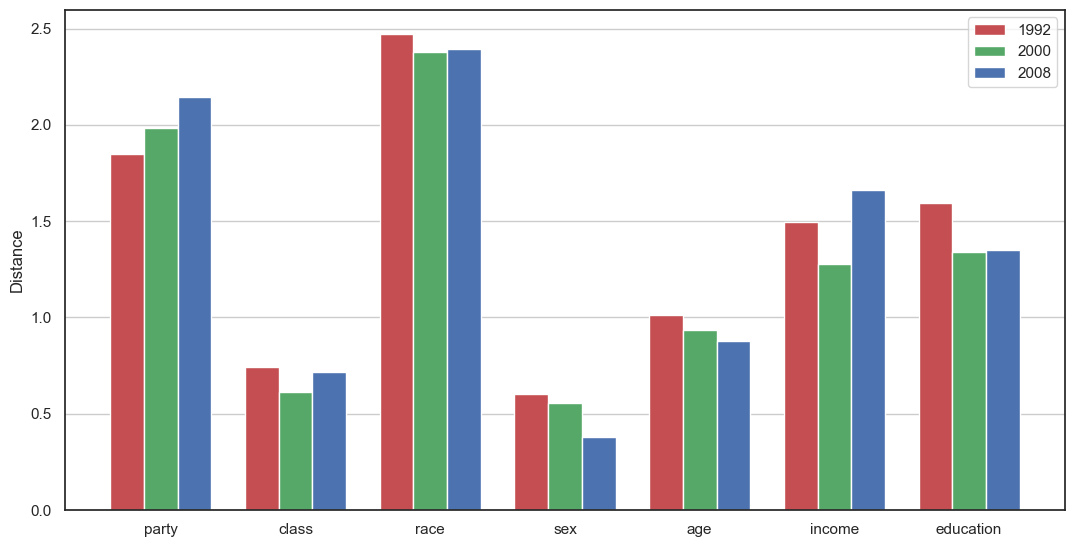

In [63]:
# distances between attribute centers

categs =  list(attributesData.keys()) ##all attributes names
col_names = ["Year"] + categs
distances = list() # to contain distances between centers
for i in range(len(yearsSubset)):
    distances.append([yearsSubset[i]])
    for att in categs:
        coords = list()
        # compute distance between both centers in the community
        for sub in subcats[att]:
            points = attributesData[att][i][sub]
            coords.append(meanPoints(np.array(points)))
        distances[i].append(math.dist(coords[0], coords[1]))
# print(tabulate(distances, headers=col_names))

# plot distances
colors = ['r','g','b', 'orange', 'purple', 'olive', 'pink', 'cyan']
fig = plt.figure(figsize=(10,5))
x = np.arange(len(col_names[1:]))
ax = fig.add_axes([0,0,1,1])

for i in range(len(yearsSubset)):
    ax.bar((x-0.25)+ (i*0.75/len(yearsSubset)) ,distances[i][1:],color=colors[i], label=yearsSubset[i], width = 0.75/len(yearsSubset))

ax.grid(axis='y')

ax.set_xticks(x)
ax.set_xticklabels(col_names[1:])
ax.set_ylabel("Distance")

ax.legend()

In [64]:
#coordinates of every community center

categs = list(attributesData.keys())

col_names = list(["Year"])
for cat in categs:
    for sc in subcats[cat]:
        col_names.append(sc)
coords = list()
for i in range(len(yearsSubset)):
    coords.append([yearsSubset[i]])
    for cat in categs:
        for sub in subcats[cat]:
            points = attributesData[cat][i][sub]
            p = meanPoints(np.array(points))
            coords[i].append((str(round(p[0], 2)), str(round(p[1], 2))))
            
coords
print(tabulate(coords, headers=col_names))

  Year  Democrats          Republicans        Middle             Working             White              Black              Female             Male               17-34              55+                 Poor                Rich               no college          college
------  -----------------  -----------------  -----------------  ------------------  -----------------  -----------------  -----------------  -----------------  -----------------  ------------------  ------------------  -----------------  ------------------  ----------------
  1992  ('0.38', '-0.34')  ('-1.08', '0.79')  ('-0.07', '0.47')  ('-0.42', '-0.18')  ('-0.37', '0.56')  ('0.56', '-1.73')  ('-0.1', '-0.11')  ('-0.43', '0.39')  ('0.12', '0.03')   ('-0.89', '-0.03')  ('-0.33', '-0.69')  ('-0.09', '0.79')  ('-0.73', '-0.47')  ('0.29', '0.76')
  2000  ('0.76', '0.04')   ('-0.87', '1.17')  ('0.16', '0.78')   ('-0.07', '0.21')   ('-0.06', '0.87')  ('0.46', '-1.45')  ('0.21', '0.35')   ('-0.19', '0.73')  ('0.44', '0.43')   (

# Null model

In [65]:
categs = list(attributesData.keys())
col_names = list(["Year"])
#get all community names for display
for c in categs:
    for sc in subcats[c]:
        col_names.append(sc)

dat = list()
# simulate random centers
numOfSimulations = 100 # stakeholder, use larger number of simulations, > than 10,000, but it is slow
for i in range(len(yearsSubset)): # make simulation for every year
    dat.append([yearsSubset[i]])
    for categ in list(attributesData.keys()): # run simulation for every attribute
        subs = subcats[categ] # get attrbute to simulate
        comm1 = np.array(attributesData[categ][i][subs[0]]) # first community of the attribute
        comm2 = np.array(attributesData[categ][i][subs[1]]) # second community of the attribute
        lenComm1 = len(comm1)
        lenComm2 = len(comm2)
        c1 = meanPoints(comm1)
        c2 = meanPoints(comm2)
        # print(f"Year {yearsSubset[i]} : {subs[0]} Q: {lenComm1} C: {c1} /////  {subs[1]} Q: {lenComm2} C: {c2} ")
        join = np.concatenate((comm1,comm2))
        centers1 = list() 
        centers2 = list()
        # find centers for random data, preserving ratio of the data (same ratio of users in each community)
        for _ in range(numOfSimulations):
            np.random.shuffle(join)
            ratio = lenComm1 / (lenComm1 + lenComm2) # % of points to be of community1
            threshold = int(len(join) * ratio) 
            centers1.append(meanPoints(join[:threshold]))
            centers2.append(meanPoints(join[threshold:]))
        centers1 = np.array(centers1)
        centers2 = np.array(centers2)
        # center of problability cloud centers
        probCloud1Center = meanPoints(centers1)
        probCloud2Center = meanPoints(centers2)

        # compute distance between every center and the center of the cloud
        centerDist1 = [math.dist(x, probCloud1Center) for x in centers1]
        centerDist2 = [math.dist(x, probCloud2Center) for x in centers2]
        
        # find "p-distance", threshold in distance dividing the 0.05 of the furthest points to the cloud center
        centerDist1.sort()
        centerDist2.sort()
        threshold1 = centerDist1[int(len(centerDist1)*0.95)]
        threshold2 = centerDist2[int(len(centerDist2)*0.95)]
        cDist1 = math.dist(c1, probCloud1Center)
        cDist2 = math.dist(c2, probCloud2Center)
        dat[i].append((str(round(cDist1, 2)), str(round(threshold1, 2)))) # (distance to real center, p-distance) comm1
        dat[i].append((str(round(cDist2, 2)), str(round(threshold2, 2)))) # (distance to real center, p-distance) comm2

        # uncomment to check if a comunity can reject the null hypothesis
        # print(f"Year {yearsSubset[i]} : {subs[0]} Center Distance: {cDist1} P 0.05: {threshold1} /////  {subs[1]} Center Distance: {cDist2} P 0.05: {threshold2} //// {cDist1>threshold1} {cDist2>threshold2}")
print('==========')
print(f"(Distance to center, Further 0.05 distance),  # iterations = {numOfSimulations}")
print('==========')
print(tabulate(dat, headers=col_names))

    


(Distance to center, Further 0.05 distance),  # iterations = 100
  Year  Democrats         Republicans       Middle            Working           White             Black             Female            Male              17-34             55+               Poor              Rich              no college        college
------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------
  1992  ('0.79', '0.1')   ('1.05', '0.14')  ('0.39', '0.11')  ('0.36', '0.1')   ('0.35', '0.04')  ('2.12', '0.27')  ('0.28', '0.08')  ('0.32', '0.09')  ('0.48', '0.1')   ('0.53', '0.12')  ('0.78', '0.12')  ('0.72', '0.11')  ('0.75', '0.11')  ('0.84', '0.12')
  2000  ('0.86', '0.09')  ('1.13', '0.12')  ('0.28', '0.12')  ('0.34', '0.14')  ('0.31', '0.05')  ('2.08', '0.31')  ('0.24', '0.1')   ('0.31', '0.12')  ('0.52', '0.15'

In [66]:
categs = list(attributesData.keys())
col_names = list(["Year"])
for c in categs:
    for sc in subcats[c]:
        col_names.append(sc)
dat = list()

for i in range(len(yearsSubset)):
    dat.append([yearsSubset[i]])
    for categ in list(attributesData.keys()):
        subs = subcats[categ]
        cat1 = np.array(attributesData[categ][i][subs[0]])
        cat2 = np.array(attributesData[categ][i][subs[1]])
        c1 = meanPoints(cat1)
        c2 = meanPoints(cat2)
        plt.show()
        centerDist1 = [math.dist(x, c1) for x in cat1]
        centerDist2 = [math.dist(x, c2) for x in cat2]
        dat[i].append((str(round(np.var(np.array(centerDist1)),2)), str(round(np.mean(np.array(centerDist1)),2)) ))
        dat[i].append((str(round(np.var(np.array(centerDist2)),2)), str(round(np.mean(np.array(centerDist2)),2)) ))
print(f"(Variance, mean)  distance to center")
print(tabulate(dat, headers=col_names))

(Variance, mean)  distance to center
  Year  Democrats         Republicans       Middle            Working           White            Black             Female            Male              17-34             55+               Poor              Rich              no college        college
------  ----------------  ----------------  ----------------  ----------------  ---------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------  ----------------
  1992  ('1.57', '2.57')  ('1.12', '2.34')  ('1.54', '2.7')   ('1.5', '2.38')   ('1.52', '2.5')  ('1.07', '2.12')  ('1.54', '2.52')  ('1.53', '2.6')   ('1.46', '2.48')  ('1.35', '2.34')  ('1.39', '2.29')  ('1.61', '2.62')  ('1.25', '2.21')  ('1.55', '2.74')
  2000  ('1.36', '2.44')  ('1.1', '2.2')    ('1.47', '2.44')  ('1.55', '2.41')  ('1.5', '2.34')  ('1.03', '2.14')  ('1.44', '2.37')  ('1.55', '2.51')  ('1.39', '2.43')  ('1.52', '2.39')  ('1.49', '2

# 2d 2-sample Kolmogorov smirnov test by syrte
 https://github.com/syrte/ndtest/



In [67]:
from __future__ import division
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    nboot : None or int
        Number of bootstrap resample to estimate the p-value. A large number is expected.
        If None, an approximate analytic estimate will be used.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic, returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. 
    Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation
    is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate,
    but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, MNRAS, 202, 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, MNRAS, 225, 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [68]:
categs = list(attributesData.keys())
col_names = list(["Year"])
for c in categs:
    col_names.append(c)
dat = list()

for i in range(len(yearsSubset)):
    dat.append([yearsSubset[i]])
    for categ in list(attributesData.keys()):
        subs = subcats[categ]
        comm1 = np.array(attributesData[categ][i][subs[0]]) #community 1 of attribute
        comm2 = np.array(attributesData[categ][i][subs[1]]) #community 2 of attribute


        x1, y1 = comm1[:,0], comm1[:,1]
        x2, y2 = comm2[:,0], comm2[:,1]
        P = ks2d2s(x1, y1, x2, y2, extra=False) # smirnov test results
        dat[i].append(f"{P=:.3g}")

print(f"Smirnov P value")
print(tabulate(dat, headers=col_names))


Smirnov P value
  Year  party       class       race        sex         age         income      education
------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
  1992  P=7.5e-38   P=1.29e-12  P=1.65e-46  P=7.78e-09  P=4.03e-12  P=7.16e-31  P=2.34e-44
  2000  P=1.71e-33  P=3.12e-07  P=2.29e-35  P=1.96e-06  P=2.38e-08  P=3.48e-16  P=6.5e-25
  2008  P=1.14e-54  P=1.05e-11  P=2.16e-76  P=0.000185  P=2.82e-09  P=1.77e-30  P=3.49e-36


# Clustering

<AxesSubplot:>

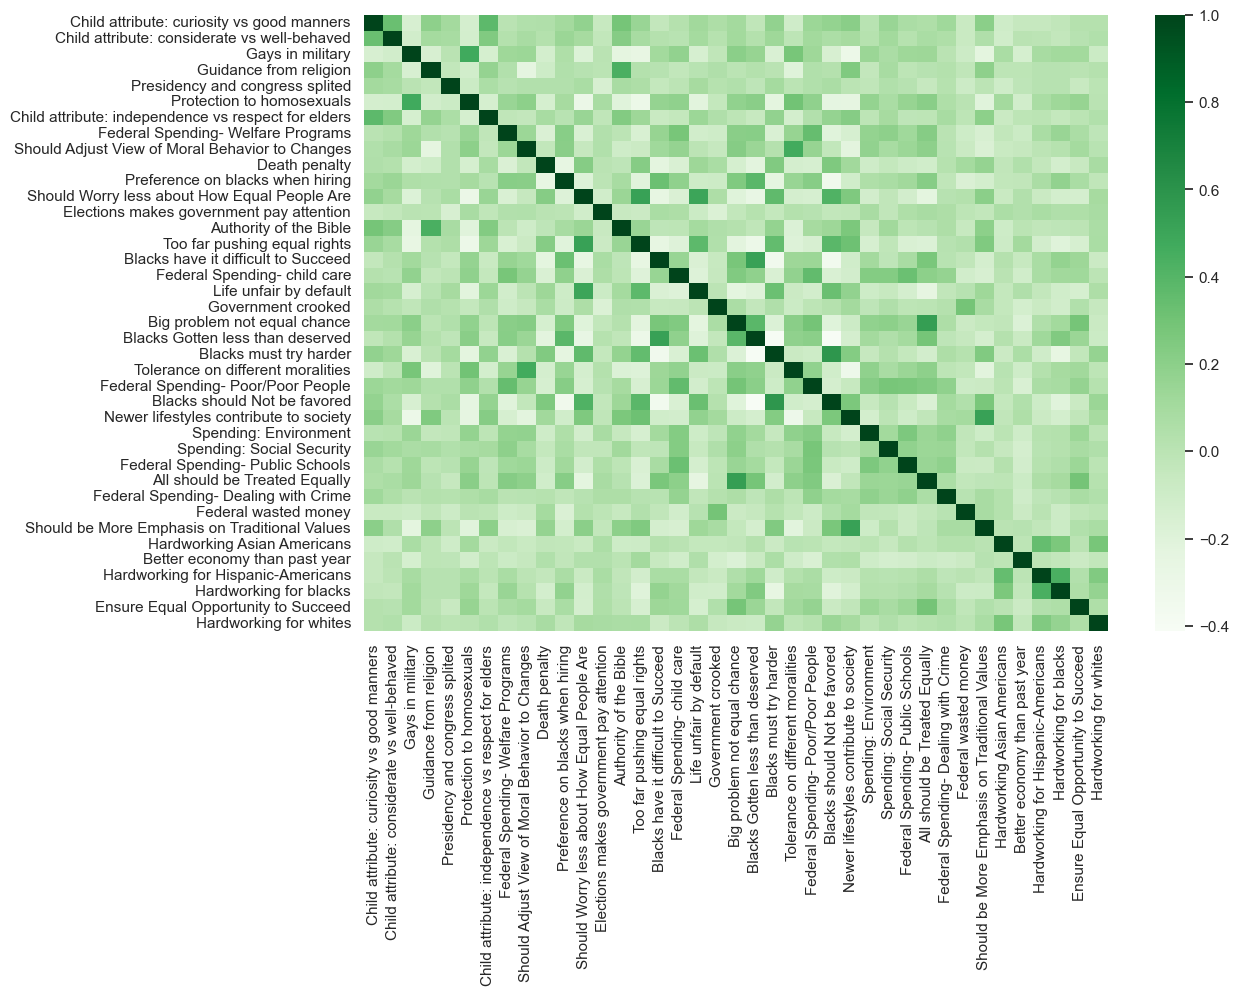

In [69]:
corr = dataframes[0].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens")

In [70]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

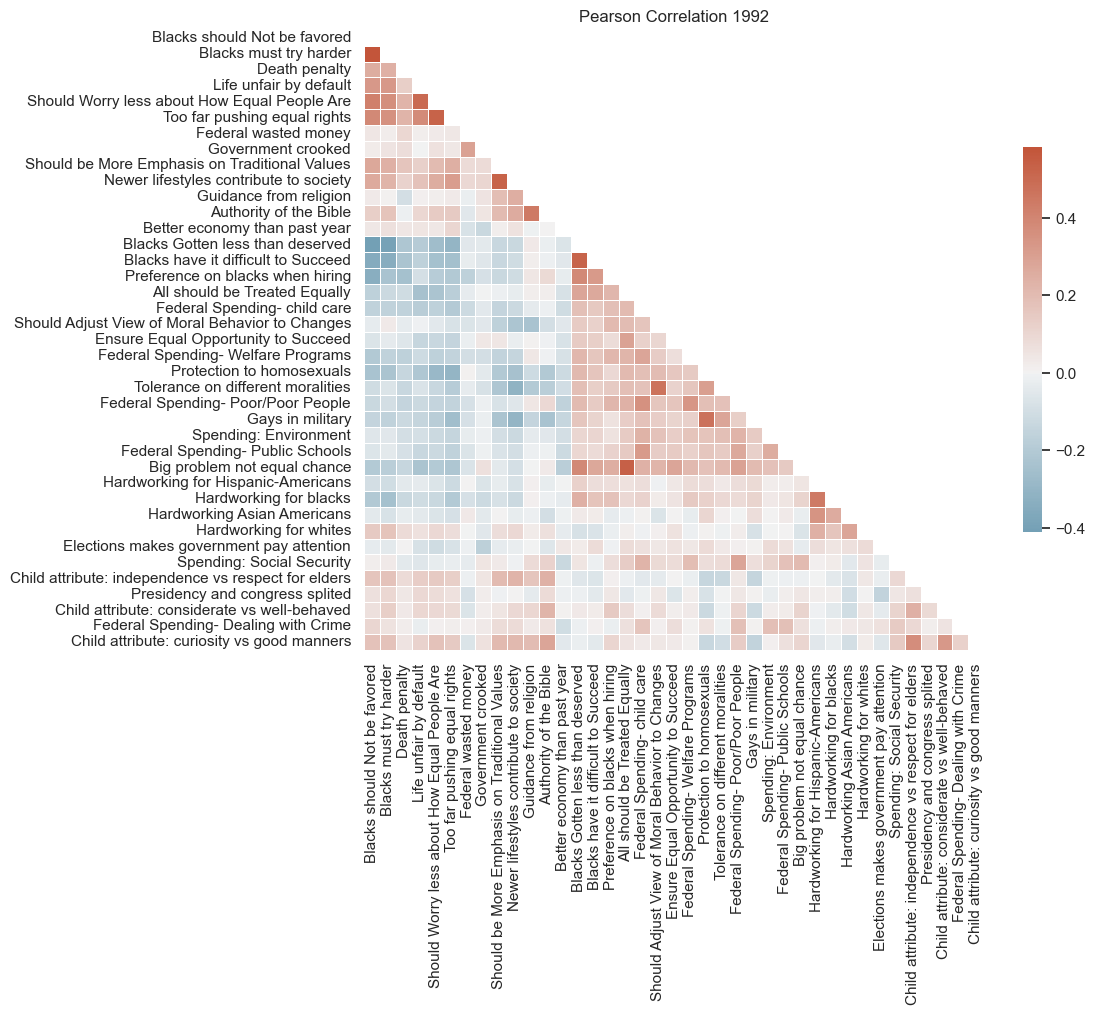

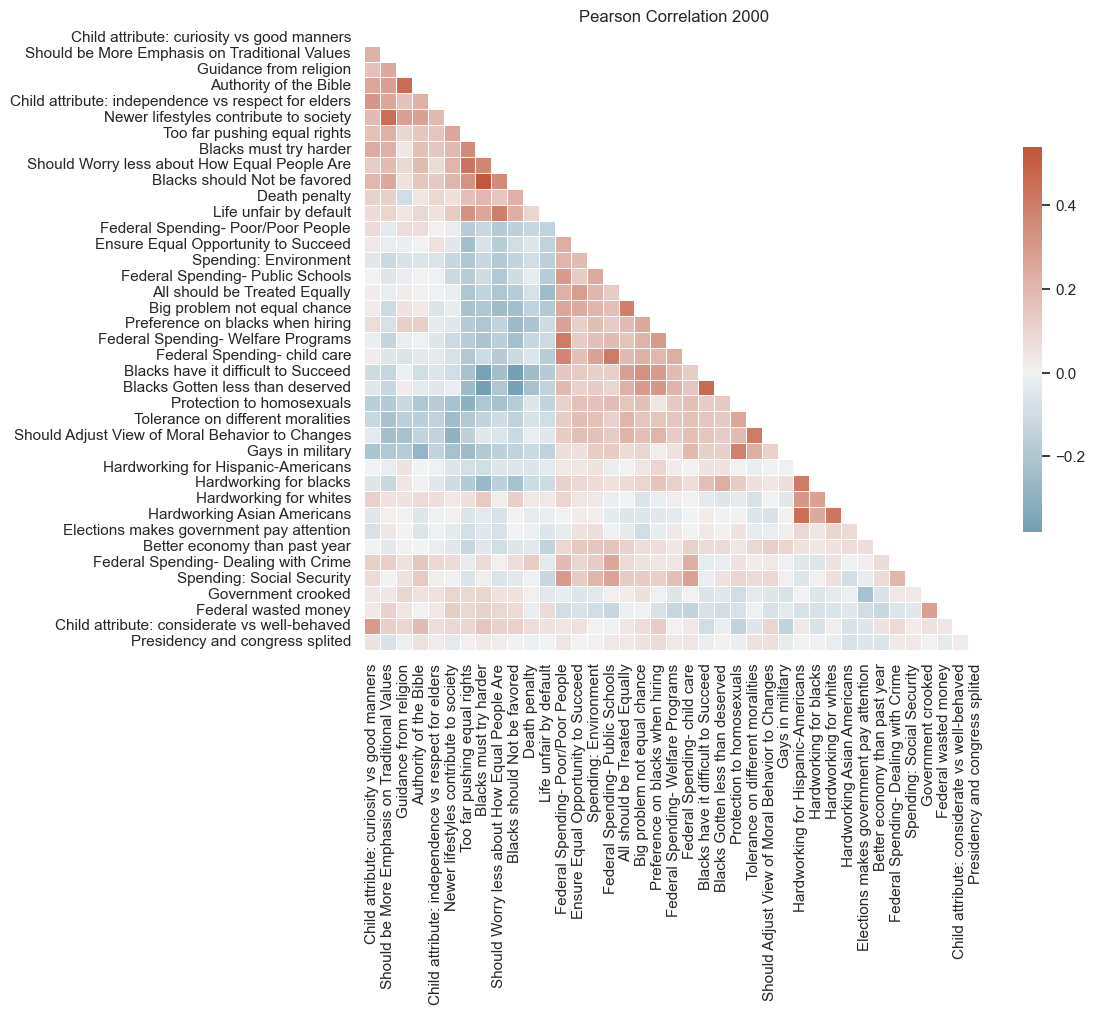

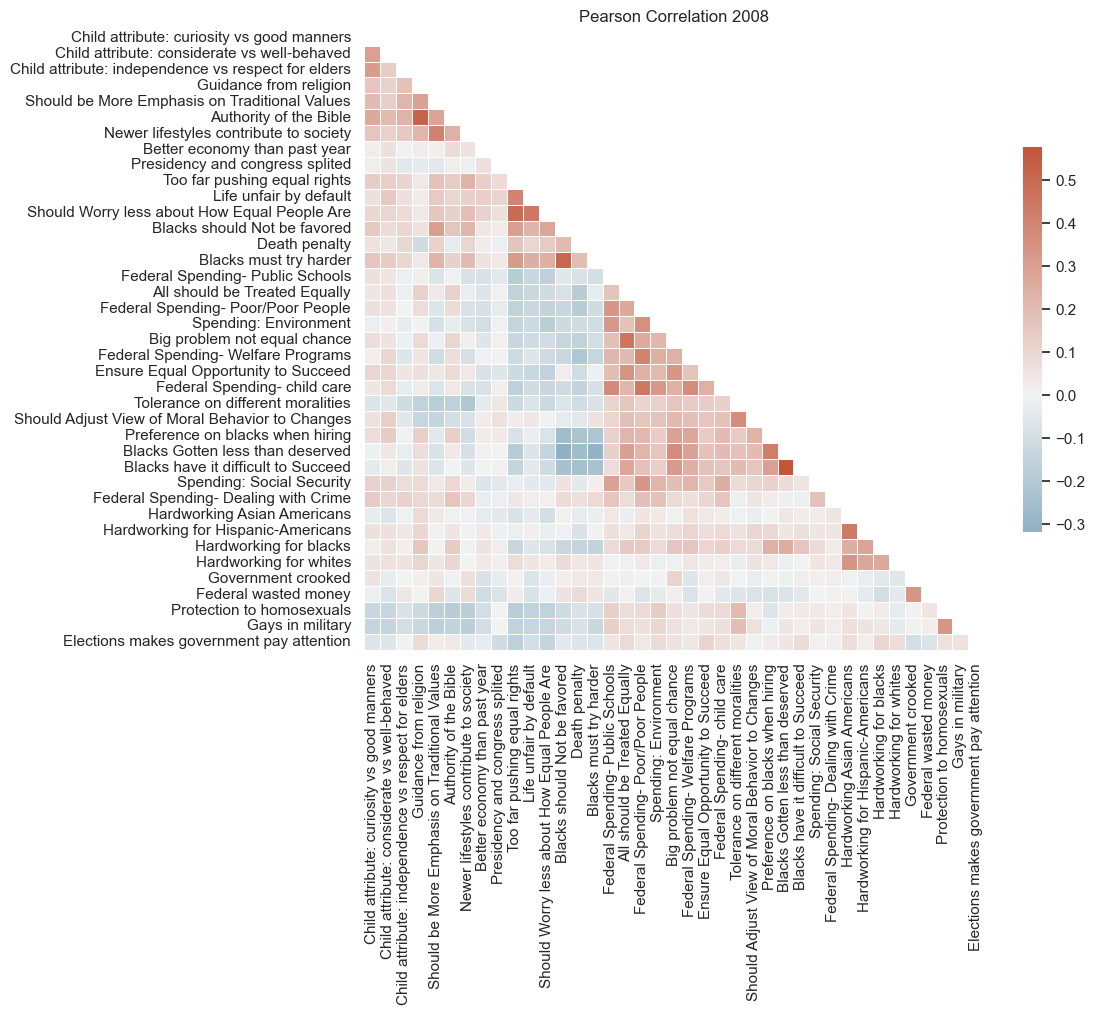

In [71]:
for i in range(len(dataframes)):
    corr = dataframes[i].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    plot = sns.heatmap(cluster_corr(corr), mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title=f"Pearson Correlation {yearsSubset[i]}")
    fig = f.get_figure()
    # fig.savefig(f"output{yearsSubset[i]}.png")

In [72]:
sortedColumns = np.sort(dataframes[0].columns)

In [73]:
categories4 = { # handmade clusters 4 categories
  "Federal Spending- Poor/Poor People": "spending",
  "Federal Spending- child care": "spending",
  "Federal Spending- Dealing with Crime": "spending",
  "Federal Spending- AIDS": "spending",
  "Federal Spending- Public Schools": "spending",
  "Federal Spending- Students": "spending",
  "Federal Spending- foreigners": "spending",
  "Federal Spending- homeless": "spending",
  "Federal Spending- Welfare Programs": "spending",
  "Federal Spending- food stamps": "spending",
  "Federal Spending- science": "spending",
  "Federal Spending- assist blacks": "spending",
  "Government Services-Spending Scale": "spending",
  "Defense Spending Scale": "spending",
  "Spending: Environment": "spending",
  "Spending: Social Security": "spending",
  "Federal wasted money": "spending",
  "Government Health Insurance": "spending",
  "Blacks have it difficult to Succeed": "group opinion",
  "Blacks should Not be favored": "group opinion",
  "Blacks must try harder": "group opinion",
  "Blacks Gotten less than deserved": "group opinion",
  "Black influence": "group opinion",
  "Segregation vs desegregation": "group opinion",
  "Whites favor segregation": "group opinion",
  "Black favor desegregation": "group opinion",
  "Ensure jobs/house for blacks": "group opinion",
  "Aid to Blacks": "group opinion",
  "Preference on blacks when hiring": "group opinion",
  "Opinion- Evangelical groups": "group opinion",
  "Opinion- elderly": "group opinion",
  "Opinion- supreme court": "group opinion",
  "Opinion- muslims": "group opinion",
  "Opinion- rich": "group opinion",
  "Opinion- christians": "group opinion",
  "Hardworking for whites": "group opinion",
  "Hardworking for blacks": "group opinion",
  "Hardworking for Hispanic-Americans": "group opinion",
  "Hardworking Asian Americans": "group opinion",
  "Child attribute: curiosity vs good manners": "group opinion",
  "Child attribute: considerate vs well-behaved": "group opinion",
  "Child attribute: independence vs respect for elders": "group opinion",
  "Guidance from religion": "group opinion",
  "Authority of the Bible": "group opinion",
  "School prayer": "group opinion",
  "Protection to homosexuals": "group opinion",
  "Gays in military": "group opinion",
  "Allow more immigrants": "group opinion",
  "Immigrants take jobs away": "group opinion",
  "Trust other people": "group opinion",
  "Satisfied with life": "group opinion",
  "Ensure Equal Opportunity to Succeed": "rights",
  "Too far pushing equal rights": "rights",
  "Big problem not equal chance": "rights",
  "Life unfair by default": "rights",
  "Should Worry less about How Equal People Are": "rights",
  "All should be Treated Equally": "rights",
  "Guaranteed equal Opportunity by govt": "rights",
  "Use school bus to integrate": "rights",
  "Protect rights of accused": "rights",
  "Women equal role": "rights",
  "Abortion allowed": "rights",
  "Abortion allowed by law": "rights",
  "Civil rights pushed too fast": "rights",
  "Tolerance on different moralities": "rights",
  "Guaranteed Jobs and Income": "rights",
  "Should Adjust View of Moral Behavior to Changes": "rights",
  "Should be More Emphasis on Traditional Values": "rights",
  "Torture": "rights",
  "Death penalty": "rights",
  "Should be harder to buy a Gun ": "rights",
  "Importance of gun control ": "rights",
  "Approve participation in protests": "rights",
  "Approve demonstrations": "rights",
  "Approve civil disobedience": "rights",
  "Government Waste Money": "politics",
  "Government crooked": "politics",
  "Government care in public opinion": "politics",
  "Government pays attention to public opinion": "politics",
  "Parties makes government pay attention": "politics",
  "Elections makes government pay attention": "politics",
  "Congressmen attention to constituents": "politics",
  "Better economy than past year": "politics",
  "Better economy next year": "politics",
  "Knowledge political issues": "politics",
  "Satisfied with democracy in U.S. (Former)": "politics",
  "Satisfied with democracy in U.S. (Latter)": "politics",
  "Interest in Elections": "politics",
  "Interest in public affairs": "politics",
  "Frequency of political discussions": "politics",
  "Trust in media": "politics",
  "Presidency and congress splited": "politics",
  "Use of military force": "politics",
  "Concern conventional war": "politics",
  "Concern nuclear war": "politics",
  "Urban unrest force-solve": "politics",
  "Harder environmental regulations": "politics",
  "Newer lifestyles contribute to society": "politics",
  "Unemployment increase": "politics"
}


In [74]:
categories5 = { # handmade clusters 5 categories
  "Federal Spending- Poor/Poor People": "spending",
  "Federal Spending- child care": "spending",
  "Federal Spending- Dealing with Crime": "spending",
  "Federal Spending- AIDS": "spending",
  "Federal Spending- Public Schools": "spending",
  "Federal Spending- Students": "spending",
  "Federal Spending- foreigners": "spending",
  "Federal Spending- homeless": "spending",
  "Federal Spending- Welfare Programs": "spending",
  "Federal Spending- food stamps": "spending",
  "Federal Spending- science": "spending",
  "Federal Spending- assist blacks": "spending",
  "Government Services-Spending Scale": "spending",
  "Defense Spending Scale": "spending",
  "Spending: Environment": "spending",
  "Spending: Social Security": "spending",
  "Federal wasted money": "spending",
  "Government Health Insurance": "spending",
  "Blacks have it difficult to Succeed": "race opinion",
  "Blacks should Not be favored": "race opinion",
  "Blacks must try harder": "race opinion",
  "Blacks Gotten less than deserved": "race opinion",
  "Black influence": "race opinion",
  "Segregation vs desegregation": "race opinion",
  "Whites favor segregation": "race opinion",
  "Black favor desegregation": "race opinion",
  "Ensure jobs/house for blacks": "race opinion",
  "Aid to Blacks": "race opinion",
  "Preference on blacks when hiring": "race opinion",
  "Opinion- muslims": "race opinion",
  "Hardworking for whites": "race opinion",
  "Hardworking for blacks": "race opinion",
  "Hardworking for Hispanic-Americans": "race opinion",
  "Hardworking Asian Americans": "race opinion",
  "Opinion- Evangelical groups": "group opinion",
  "Opinion- elderly": "group opinion",
  "Opinion- supreme court": "group opinion",
  "Opinion- rich": "group opinion",
  "Opinion- christians": "group opinion",
  "Child attribute: curiosity vs good manners": "group opinion",
  "Child attribute: considerate vs well-behaved": "group opinion",
  "Child attribute: independence vs respect for elders": "group opinion",
  "Guidance from religion": "group opinion",
  "Authority of the Bible": "group opinion",
  "School prayer": "group opinion",
  "Protection to homosexuals": "group opinion",
  "Gays in military": "group opinion",
  "Allow more immigrants": "group opinion",
  "Immigrants take jobs away": "group opinion",
  "Trust other people": "group opinion",
  "Ensure Equal Opportunity to Succeed": "rights",
  "Too far pushing equal rights": "rights",
  "Big problem not equal chance": "rights",
  "Life unfair by default": "rights",
  "Should Worry less about How Equal People Are": "rights",
  "All should be Treated Equally": "rights",
  "Guaranteed equal Opportunity by govt": "rights",
  "Use school bus to integrate": "rights",
  "Protect rights of accused": "rights",
  "Women equal role": "rights",
  "Abortion allowed": "rights",
  "Abortion allowed by law": "rights",
  "Civil rights pushed too fast": "rights",
  "Tolerance on different moralities": "rights",
  "Guaranteed Jobs and Income": "rights",
  "Should Adjust View of Moral Behavior to Changes": "rights",
  "Should be More Emphasis on Traditional Values": "rights",
  "Torture": "rights",
  "Death penalty": "rights",
  "Should be harder to buy a Gun ": "rights",
  "Importance of gun control ": "rights",
  "Approve participation in protests": "rights",
  "Approve demonstrations": "rights",
  "Approve civil disobedience": "rights",
  "Government Waste Money": "politics",
  "Government crooked": "politics",
  "Government care in public opinion": "politics",
  "Government pays attention to public opinion": "politics",
  "Parties makes government pay attention": "politics",
  "Elections makes government pay attention": "politics",
  "Congressmen attention to constituents": "politics",
  "Better economy than past year": "politics",
  "Better economy next year": "politics",
  "Knowledge political issues": "politics",
  "Satisfied with democracy in U.S. (Former)": "politics",
  "Satisfied with democracy in U.S. (Latter)": "politics",
  "Interest in Elections": "politics",
  "Interest in public affairs": "politics",
  "Frequency of political discussions": "politics",
  "Trust in media": "politics",
  "Presidency and congress splited": "politics",
  "Use of military force": "politics",
  "Concern conventional war": "politics",
  "Concern nuclear war": "politics",
  "Urban unrest force-solve": "politics",
  "Harder environmental regulations": "politics",
  "Newer lifestyles contribute to society": "politics",
  "Unemployment increase": "politics",
  "Satisfied with life": "politics"
}


In [75]:
categories6 = { # handmade clusters 6 categories
  "Federal Spending- Poor/Poor People": "spending",
  "Federal Spending- child care": "spending",
  "Federal Spending- Dealing with Crime": "spending",
  "Federal Spending- AIDS": "spending",
  "Federal Spending- Public Schools": "spending",
  "Federal Spending- Students": "spending",
  "Federal Spending- foreigners": "spending",
  "Federal Spending- homeless": "spending",
  "Federal Spending- Welfare Programs": "spending",
  "Federal Spending- food stamps": "spending",
  "Federal Spending- science": "spending",
  "Federal Spending- assist blacks": "spending",
  "Government Services-Spending Scale": "spending",
  "Defense Spending Scale": "spending",
  "Spending: Environment": "spending",
  "Spending: Social Security": "spending",
  "Federal wasted money": "spending",
  "Government Health Insurance": "spending",

  "Blacks have it difficult to Succeed": "race opinion",
  "Blacks should Not be favored": "race opinion",
  "Blacks must try harder": "race opinion",
  "Blacks Gotten less than deserved": "race opinion",
  "Black influence": "race opinion",
  "Segregation vs desegregation": "race opinion",
  "Whites favor segregation": "race opinion",
  "Black favor desegregation": "race opinion",
  "Ensure jobs/house for blacks": "race opinion",
  "Aid to Blacks": "race opinion",
  "Preference on blacks when hiring": "race opinion",
  "Opinion- muslims": "race opinion",
  "Hardworking for whites": "race opinion",
  "Hardworking for blacks": "race opinion",
  "Hardworking for Hispanic-Americans": "race opinion",
  "Hardworking Asian Americans": "race opinion",

  "Opinion- Evangelical groups": "group opinion",
  "Opinion- elderly": "group opinion",
  "Opinion- supreme court": "group opinion",
  "Opinion- rich": "group opinion",
  "Opinion- christians": "group opinion",
  "Child attribute: curiosity vs good manners": "group opinion",
  "Child attribute: considerate vs well-behaved": "group opinion",
  "Child attribute: independence vs respect for elders": "group opinion",
  "Guidance from religion": "group opinion",
  "Authority of the Bible": "group opinion",
  "School prayer": "group opinion",
  "Protection to homosexuals": "group opinion",
  "Gays in military": "group opinion",
  "Allow more immigrants": "group opinion",
  "Immigrants take jobs away": "group opinion",
  "Trust other people": "group opinion",

  "Ensure Equal Opportunity to Succeed": "rights",
  "Too far pushing equal rights": "rights",
  "Big problem not equal chance": "rights",
  "Life unfair by default": "rights",
  "Should Worry less about How Equal People Are": "rights",
  "All should be Treated Equally": "rights",
  "Guaranteed equal Opportunity by govt": "rights",
  "Use school bus to integrate": "rights",
  "Protect rights of accused": "rights",
  "Women equal role": "rights",
  "Abortion allowed": "rights",
  "Abortion allowed by law": "rights",
  "Civil rights pushed too fast": "rights",
  "Tolerance on different moralities": "rights",
  "Guaranteed Jobs and Income": "rights",
  "Should Adjust View of Moral Behavior to Changes": "rights",
  "Should be More Emphasis on Traditional Values": "rights",
  "Approve participation in protests": "rights",
  "Approve demonstrations": "rights",
  "Approve civil disobedience": "rights",

  "Government Waste Money": "politics",
  "Government crooked": "politics",
  "Government care in public opinion": "politics",
  "Government pays attention to public opinion": "politics",
  "Parties makes government pay attention": "politics",
  "Elections makes government pay attention": "politics",
  "Congressmen attention to constituents": "politics",
  "Better economy than past year": "politics",
  "Better economy next year": "politics",
  "Knowledge political issues": "politics",
  "Satisfied with democracy in U.S. (Former)": "politics",
  "Satisfied with democracy in U.S. (Latter)": "politics",
  "Interest in Elections": "politics",
  "Interest in public affairs": "politics",
  "Frequency of political discussions": "politics",
  "Trust in media": "politics",
  "Presidency and congress splited": "politics",
  "Harder environmental regulations": "politics",
  "Newer lifestyles contribute to society": "politics",
  "Unemployment increase": "politics",
  "Satisfied with life": "politics",

  "Urban unrest force-solve": "force",
  "Use of military force": "force",
  "Concern conventional war": "force",
  "Concern nuclear war": "force",
  "Torture": "force",
  "Death penalty": "force",
  "Should be harder to buy a Gun ": "force",
  "Importance of gun control ": "force"

}


In [76]:
# def replace(l, old, new):
#     d = dict(zip(old, new))
#     return [d.get(e, e) for e in l]

In [77]:
def compareClusters(dataframes, realClusters):
    """ Plot mutual info score between "real" clusters and generated clusters using diverse methods

    Parameters:
    dataframes -- list of dataframes
    realClusters -- real clusters defined
    """
    toPlot = list()

    #scipy methods to check when creating the agglomerative clusters
    methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
    for meth in methods:
        # create correlation matrix for every year, then create clusters, #clusters = len(realClusters)
        clusterBelonging = list()
        for i in range(len(yearsSubset)):
            corr = dataframes[i].corr() # correlation
            corr = abs(corr) #absolute value of correlation
            dissimilarity = 1 - abs(corr) 
            Z = linkage(squareform(dissimilarity), meth, optimal_ordering=False) #agglomerative hierarchical clustering (tree)
            labels = fcluster(Z, t=len(np.unique(realClusters)), criterion='maxclust') # create clusters
            clusterBelonging.append(labels)

        # link every question with its group
        clusters = list()
        for y in range(len(yearsSubset)):
            groups = {}
            quest = dataframes[y].columns
            labels = ['C'+str(x) for x in clusterBelonging[y]]
            for i in range(len(labels)):
                groups[quest[i]] = labels[i]
            clusters.append(groups)

        # every years clusters
        foundClusters = list()
        for i in range(len(yearsSubset)):
            foundClusters.append([clusters[i][x] for x in sortedColumns])

        # mutual info score between "real" and found clusters
        aux = list()
        for found in foundClusters:
            aux.append(normalized_mutual_info_score(realClusters, found))
        toPlot.append(aux)

    fig, ax = plt.subplots(figsize=(7, 5))
    for i in range(len(toPlot)):
        cols = yearsSubset
        y = toPlot[i]

        plt.tick_params(labelbottom=True,labeltop=False)
        plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='left')
        ax.plot(cols,y, '-o', label=str(methods[i]))
        plt.title("Community comparison by linkage method (compared to handpicked clusters)")
    plt.legend()

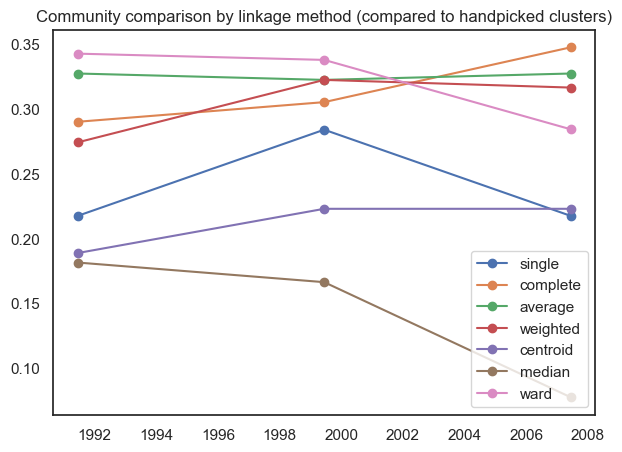

In [78]:
real = np.array([categories4[x] for x in sortedColumns])
compareClusters(dataframes,real)

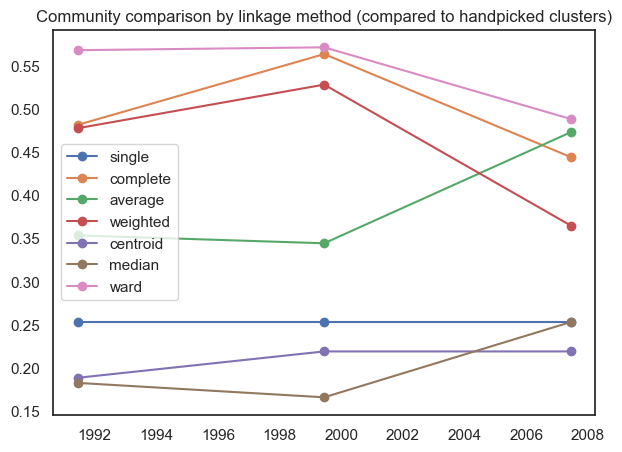

In [79]:
real = np.array([categories5[x] for x in sortedColumns]) 
compareClusters(dataframes,real)

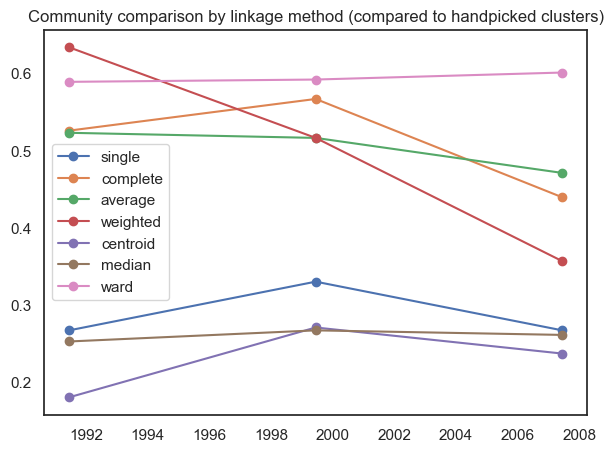

In [80]:
real = np.array([categories6[x] for x in sortedColumns])
compareClusters(dataframes,real)

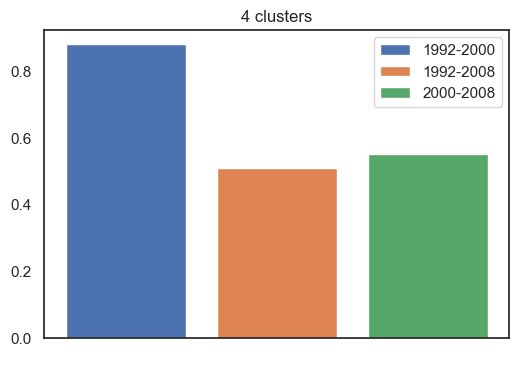

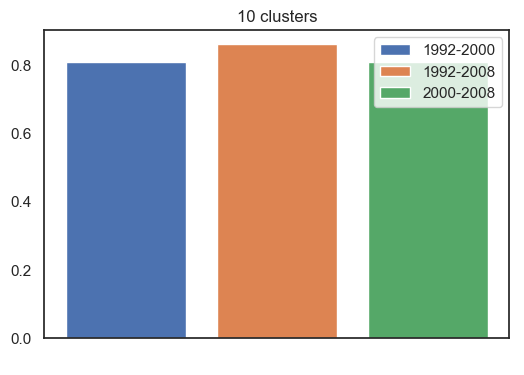

In [81]:
# comparison only between generated clusters (currently working only for sets of 3 surveys) (years hardcoded to be 1992,2000,2008)

for numOfClusters in [4,10]: # for every number of clusters in the list

    # create clusters
    clusterBelonging = list()
    for i in range(len(yearsSubset)):
        corr = dataframes[i].corr()
        corr = abs(corr)
        dissimilarity = 1 - abs(corr)
        Z = linkage(squareform(dissimilarity), 'ward', optimal_ordering=False)
        labels = fcluster(Z, t=numOfClusters, criterion='maxclust')
        clusterBelonging.append(labels)

    # link clusters to the questions
    clusters = list()
    for y in range(len(yearsSubset)):
        groups = {}
        quest = dataframes[y].columns
        labels = ['C'+str(x) for x in clusterBelonging[y]]
        for i in range(len(labels)):
            groups[quest[i]] = labels[i]
        clusters.append(groups)

    # every years clusters
    foundClusters = list()
    for i in range(len(yearsSubset)):
        foundClusters.append([clusters[i][x] for x in sortedColumns])


    # mutual info score between found clusters
    lab = ["1992-2000", "1992-2008", "2000-2008"]
    relations = ([normalized_mutual_info_score(foundClusters[0], foundClusters[1]),normalized_mutual_info_score(foundClusters[0], foundClusters[2]),normalized_mutual_info_score(foundClusters[1], foundClusters[2])])
    plt.figure(figsize=(6,4))
    for (num,rel) in enumerate(relations):
        plt.bar(num,rel,label=lab[num])
    plt.legend()
    plt.title(f"{numOfClusters} clusters")
    plt.xticks(color='w')
    plt.show()
